### Notebook that takes any run and timestamp and extracts the relevant topological information

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/gluster/data/next/notebooks/john_books/sanity_booklet/HE_calibration/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm

import functions_HE as func


# load in isaura with these functions

In [2]:
def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x

    
    
    

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        
        particles       :       pandas.DataFrame
                                Concatenated DataFrame containing the /MC/particles data from all h5 files, with the 'event_id' column modified.

        eventmap        :       pandas.DataFrame
                                Concatenated DataFrame containing the event map from all h5 files.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list = results

    # Concatenate all the dataframes at once
    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    return tracks

# Define run number and timestamp here for access

In [52]:
RUN_NUMBER = 15107
TIMESTAMP  = '150525'

### make a folder to store plots

In [53]:
# relative to the toolbox
folder_name = f'{RUN_NUMBER}_{TIMESTAMP}/'
folder_path = Path(folder_name)
folder_path.mkdir(parents=True, exist_ok=True)


# sub folders
sub_folders = ['energy', 'topology', 'geometry', 'blob']

for sub in sub_folders:
    folder_s = Path(f'{folder_name}{sub}')
    folder_s.mkdir(parents=True, exist_ok=True)

## load it in

In [54]:
# whole thing
n100_dir = f'/gluster/data/next/files/TOPOLOGY_John/N100_data/{RUN_NUMBER}/isaura/{TIMESTAMP}/'

hdst = []

for i in tqdm(range(1,8)):
    print(f"LDC {i}")
    folder_path = n100_dir + 'ldc' + str(i) + '/'
    hdst.append(load_data_fast(folder_path))

hdst = pd.concat(hdst)

  0%|          | 0/7 [00:00<?, ?it/s]

LDC 1
File /gluster/data/next/files/TOPOLOGY_John/N100_data/15107/isaura/150525/ldc1/isaura_run_15107_0676_ldc1_150525.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /gluster/data/next/files/TOPOLOGY_John/N100_data/15107/isaura/150525/ldc1/isaura_run_15107_0876_ldc1_150525.h5 broke with error:
group ``/`` does not have a child named ``Tracking``


 14%|█▍        | 1/7 [00:11<01:06, 11.03s/it]

LDC 2


 29%|██▊       | 2/7 [00:22<00:55, 11.06s/it]

LDC 3


 43%|████▎     | 3/7 [00:32<00:43, 10.81s/it]

LDC 4
File /gluster/data/next/files/TOPOLOGY_John/N100_data/15107/isaura/150525/ldc4/isaura_run_15107_1355_ldc4_150525.h5 broke with error:
group ``/`` does not have a child named ``Tracking``


 57%|█████▋    | 4/7 [00:42<00:31, 10.54s/it]

LDC 5


 71%|███████▏  | 5/7 [00:53<00:21, 10.63s/it]

LDC 6


 86%|████████▌ | 6/7 [01:04<00:10, 10.62s/it]

LDC 7


100%|██████████| 7/7 [01:15<00:00, 10.72s/it]


# Plots

- Energy distribution and distribution of all variables

In [55]:
hdst.columns.values

array(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min',
       'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave',
       'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z',
       'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y',
       'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2',
       'ovlp_blob_energy', 'vox_size_x', 'vox_size_y', 'vox_size_z'],
      dtype=object)

In [56]:
top_vars  = ['length', 'numb_of_voxels',
             'numb_of_hits', 'numb_of_tracks']

top_labels = ['length (mm)', 'number of voxels',
              'number of hits', 'number of tracks']

geo_vars  = ['x_min', 'y_min', 'z_min',
             'r_min', 'x_max', 'y_max', 
             'z_max', 'r_max', 'x_ave',
             'y_ave', 'z_ave', 'r_ave']

geo_labels = ['(mm)'] * len(geo_vars)

blob_vars = ['extreme1_x', 'extreme1_y', 'extreme1_z',
             'extreme2_x', 'extreme2_y', 'extreme2_z', 
             'blob1_x', 'blob1_y', 'blob1_z', 
             'blob2_x', 'blob2_y', 'blob2_z', 
             'eblob1', 'eblob2',
             'ovlp_blob_energy']

blob_labels = ['mm'] * len(blob_vars[-3]) + ['Energy (MeV)'] * 3

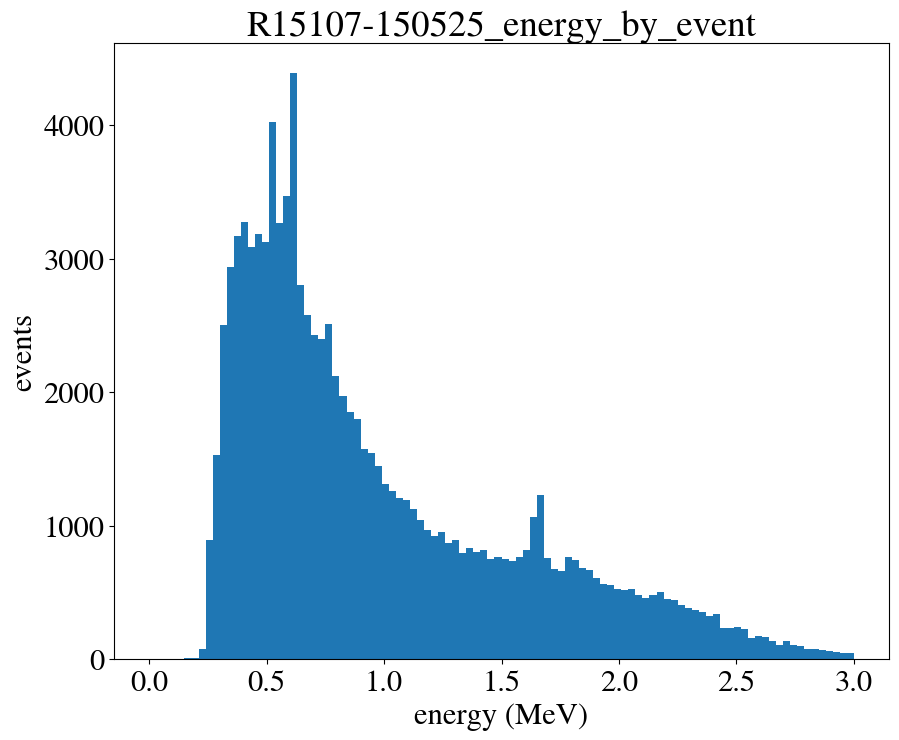

In [57]:
func.plot_hist_over_column(hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_by_event'
                           , save = True
                           , save_dir = f'{folder_name}energy/')

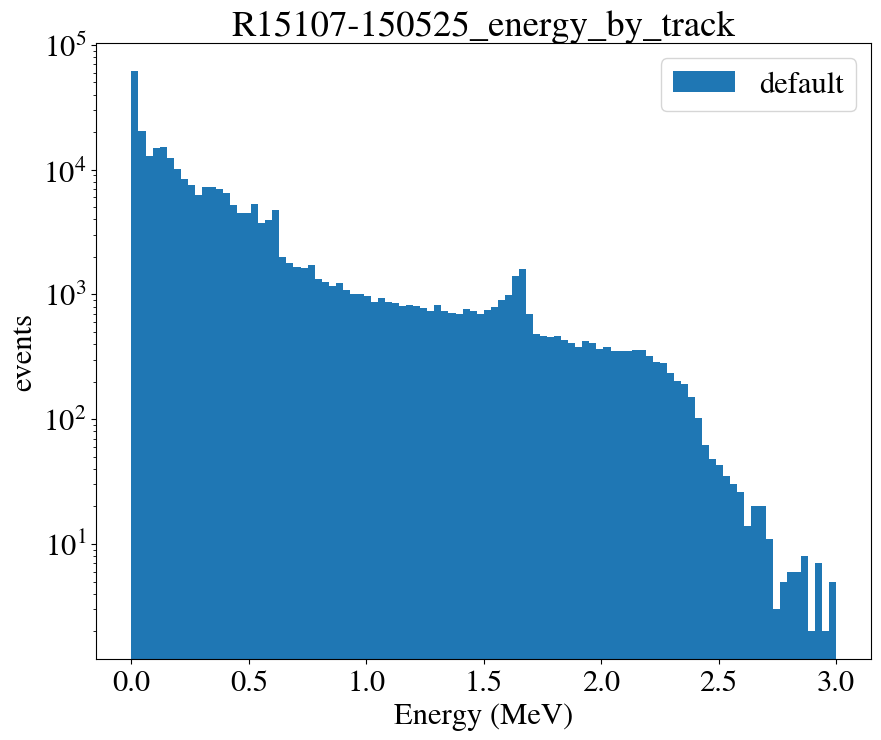

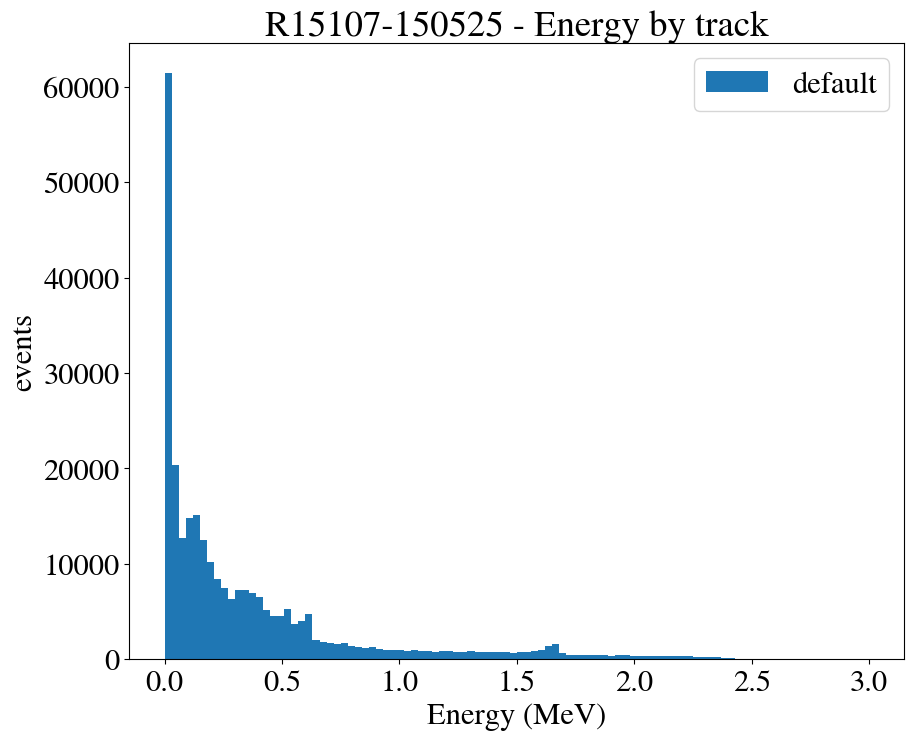

In [58]:
func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_by_track'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP} - Energy by track'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = False
              , output  = True)

In [59]:
log_flag = True

# Topological output

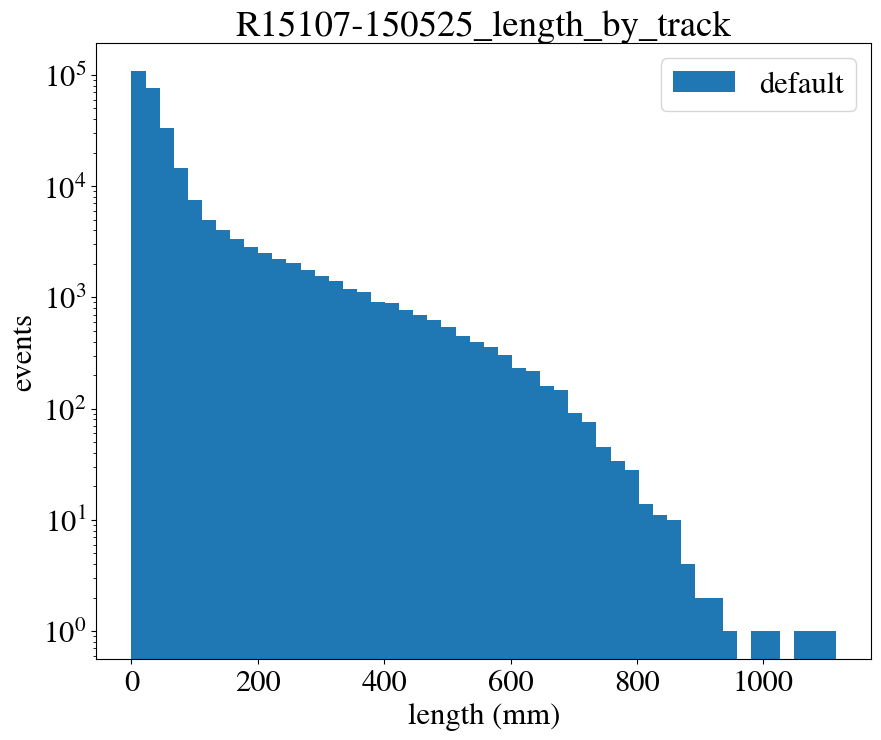

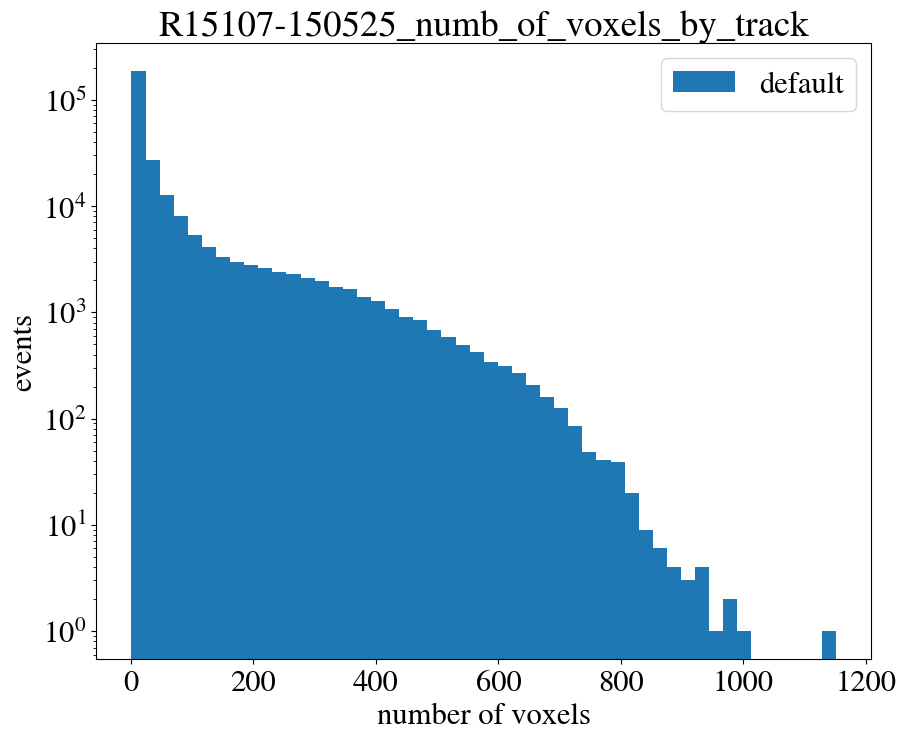

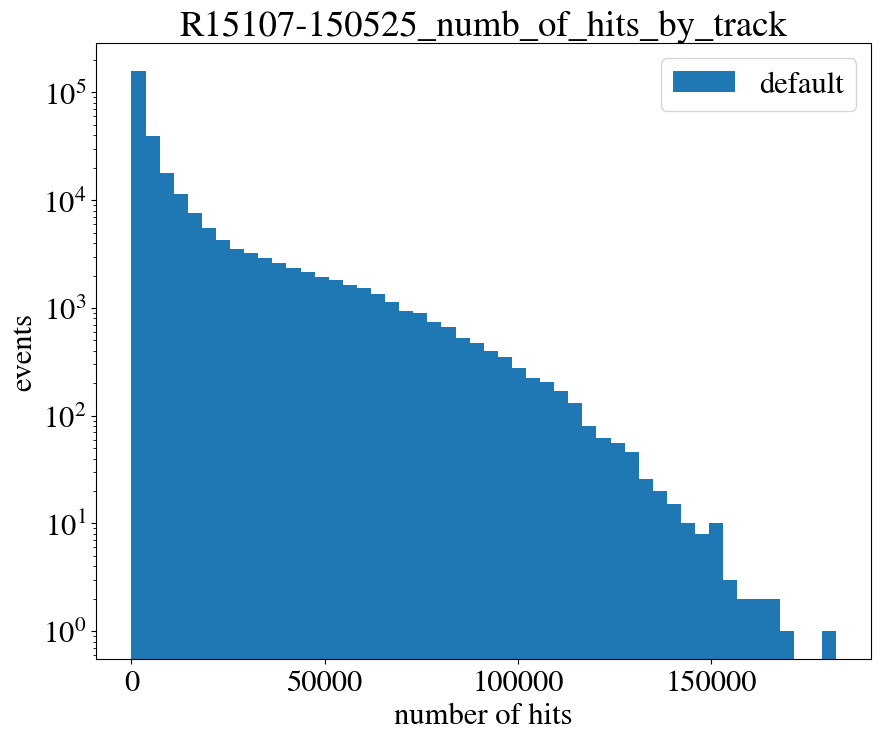

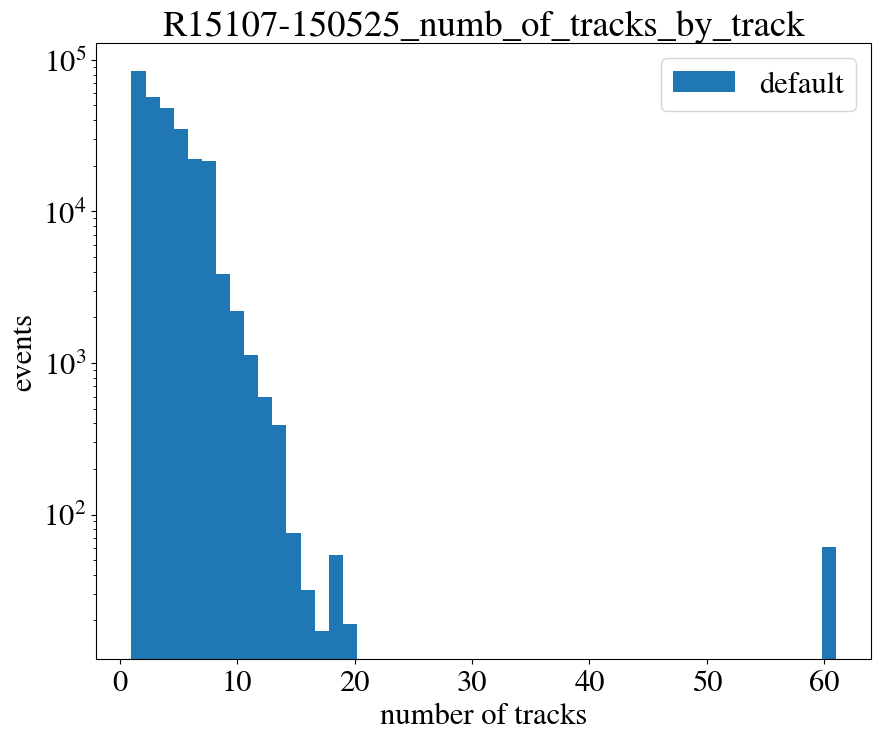

In [60]:
for vars, labels in zip(top_vars, top_labels):
    func.plot_hist( hdst
                  , vars
                  , binning  = 50
                  , title    = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_by_track'
                  , x_label  = f'{labels}'
                  , outliers = (0, 99.99999)
                  , log      = log_flag
                  , output   = True
                  , save     = True
                  , save_dir = f'{folder_name}topology/')

# Geometric output

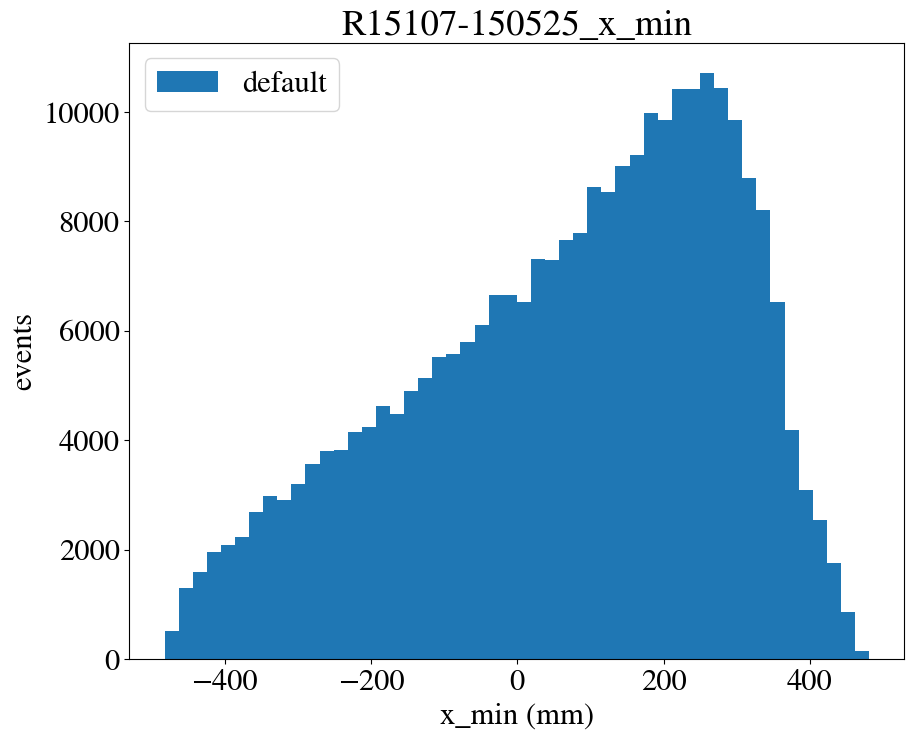

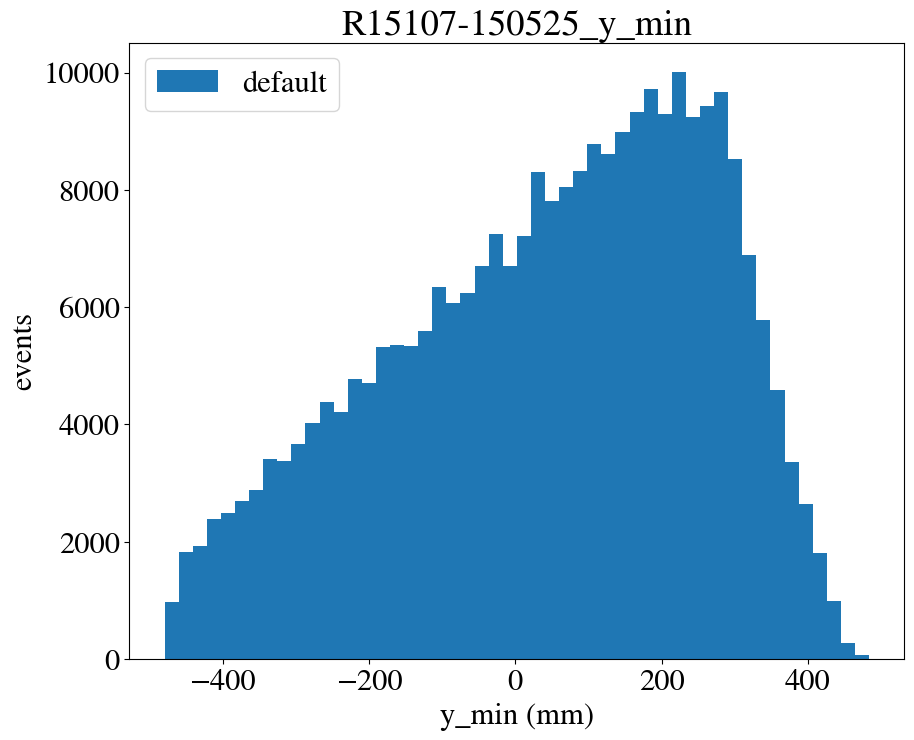

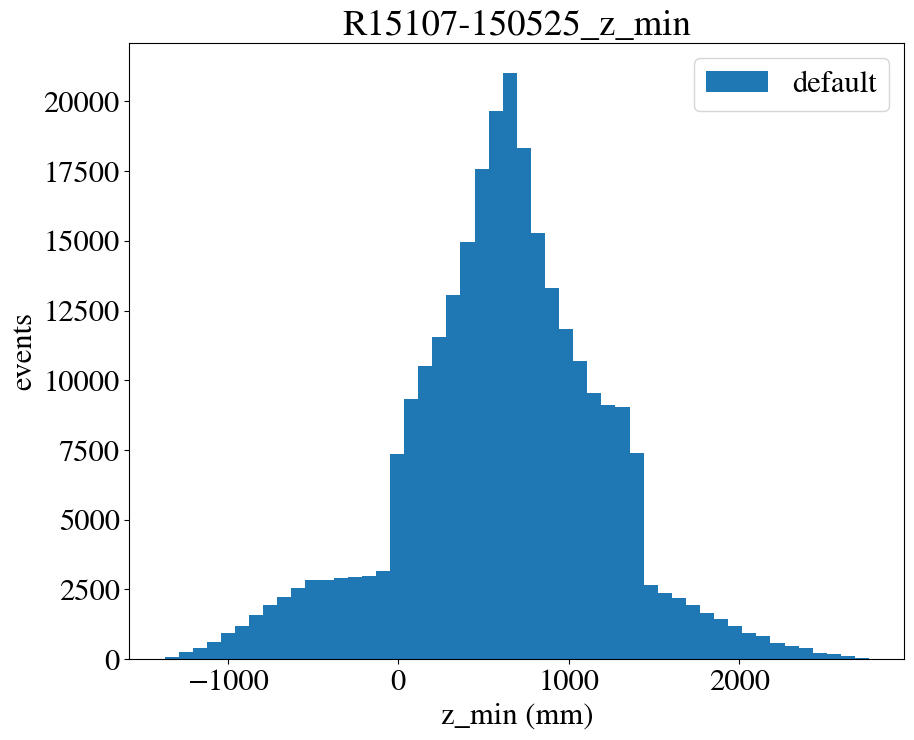

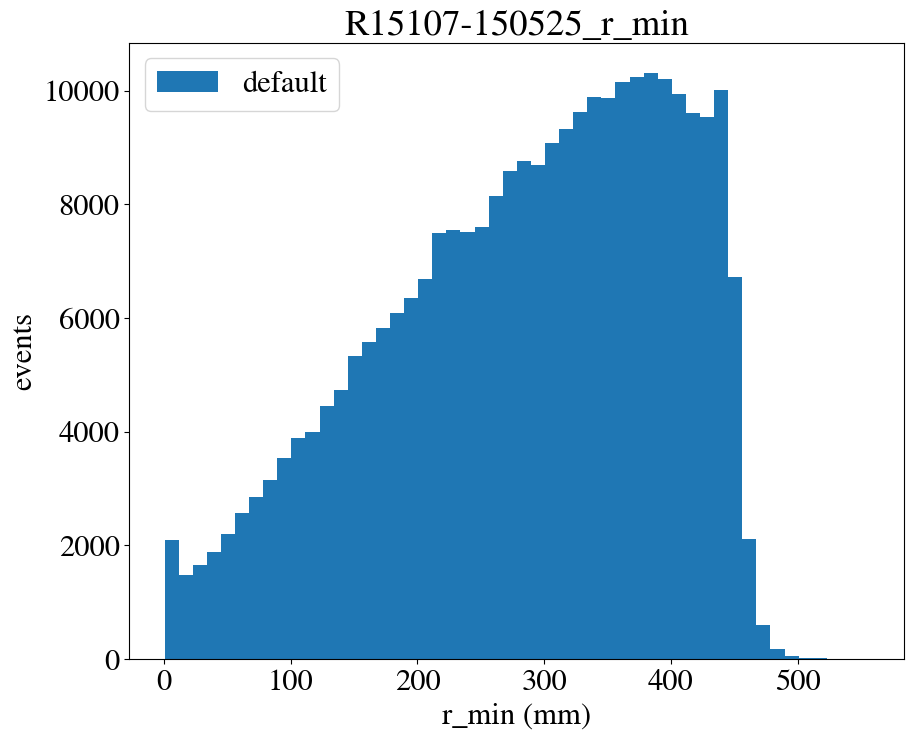

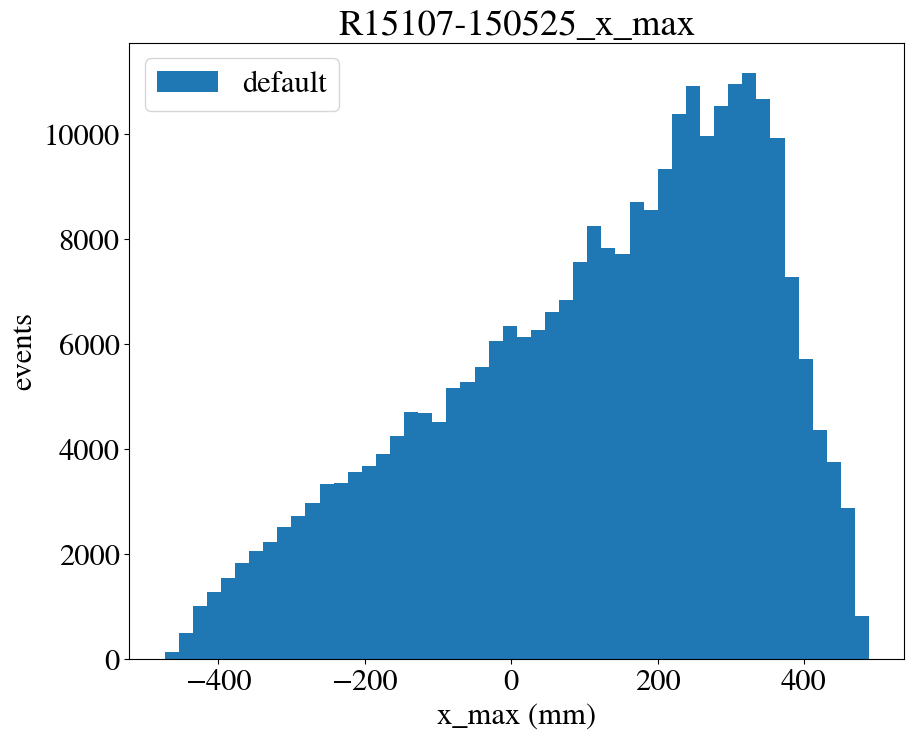

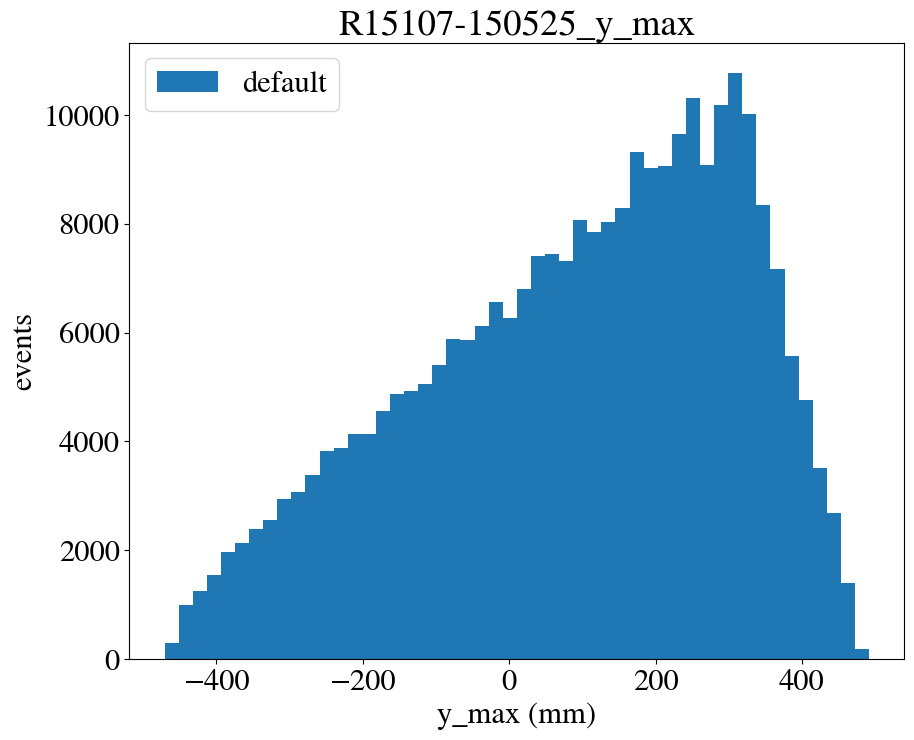

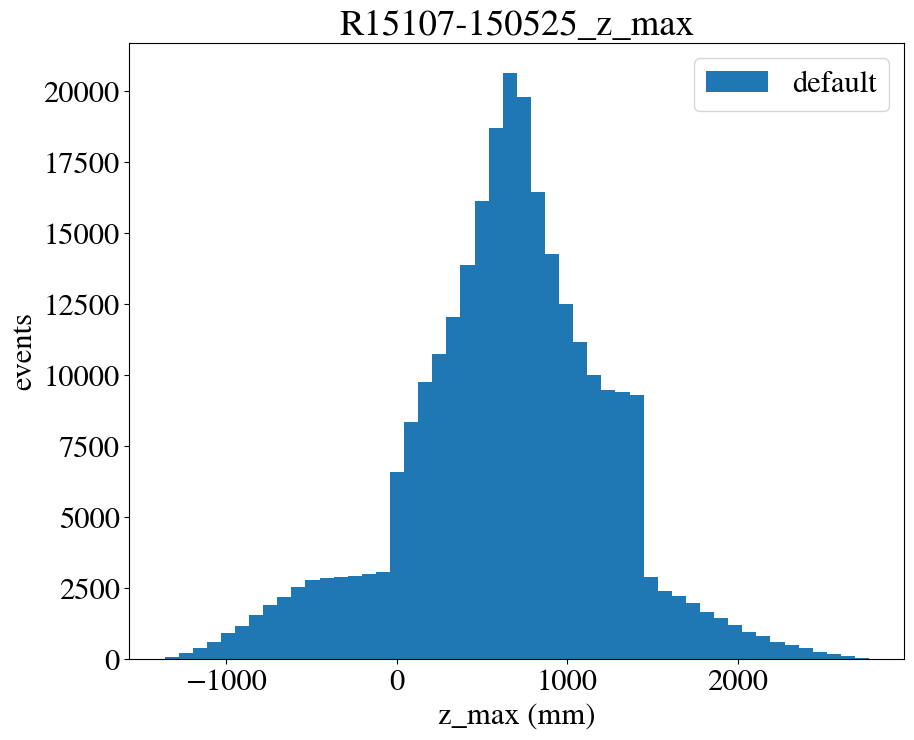

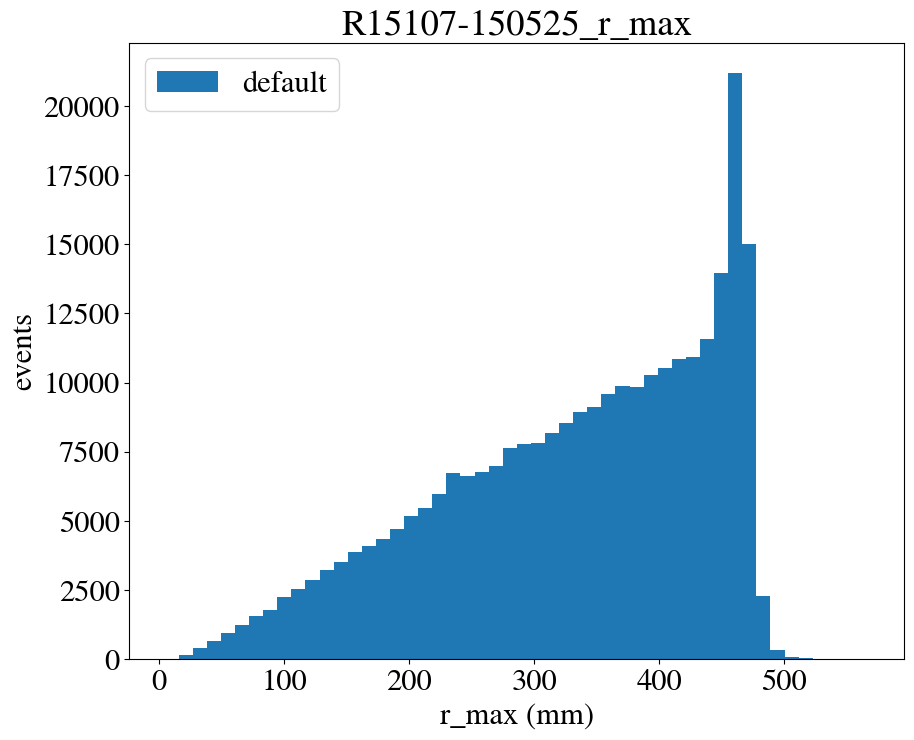

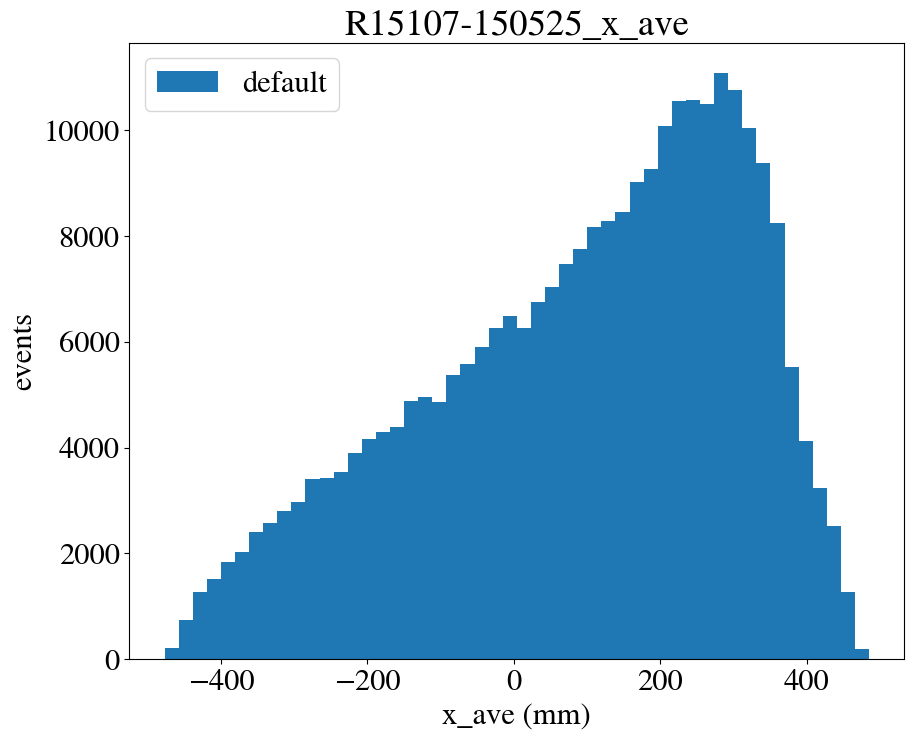

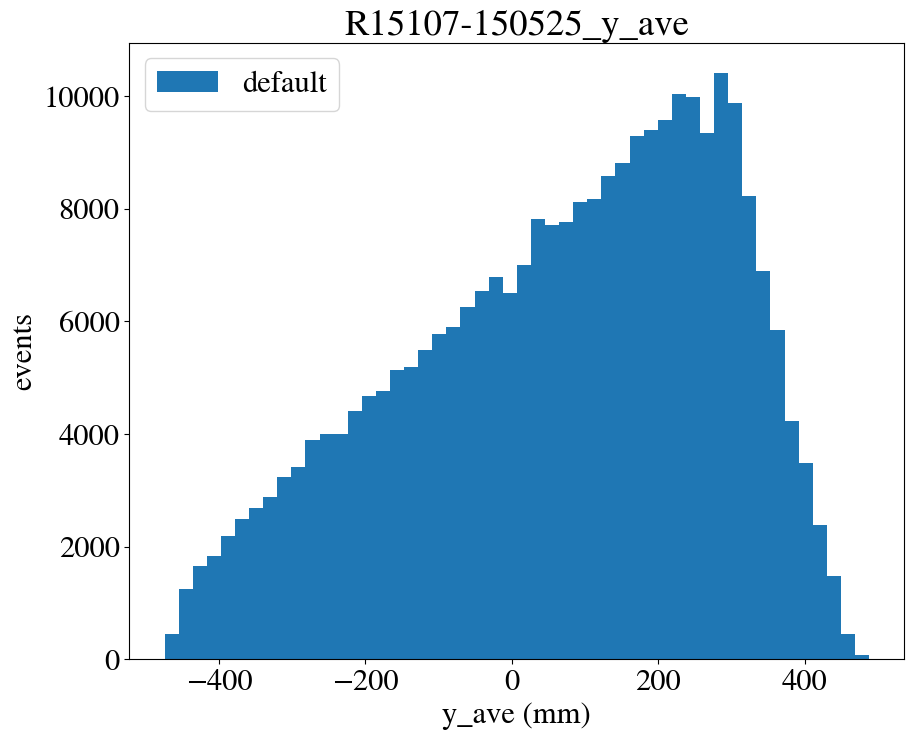

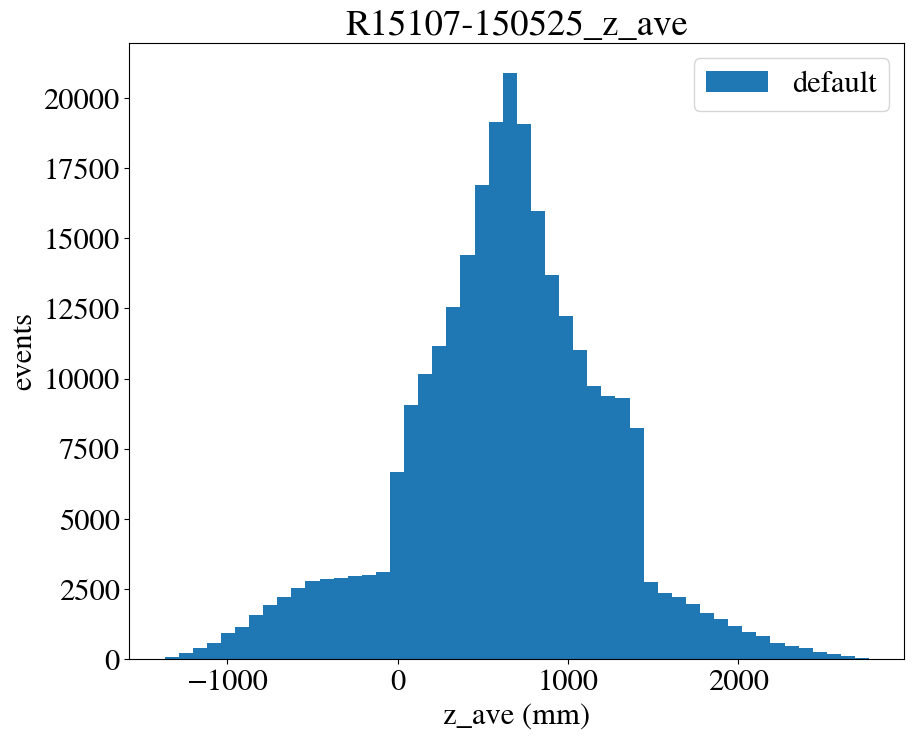

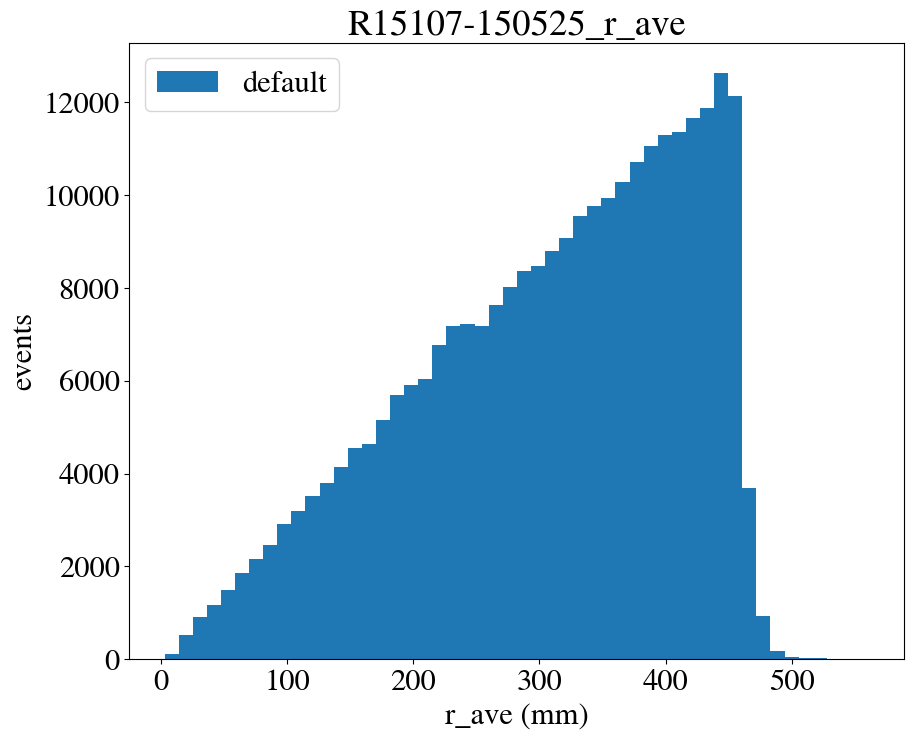

In [61]:
log_flag = False
for vars, labels in zip(geo_vars, geo_labels):
    func.plot_hist( hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}geometry/')

# blob related output

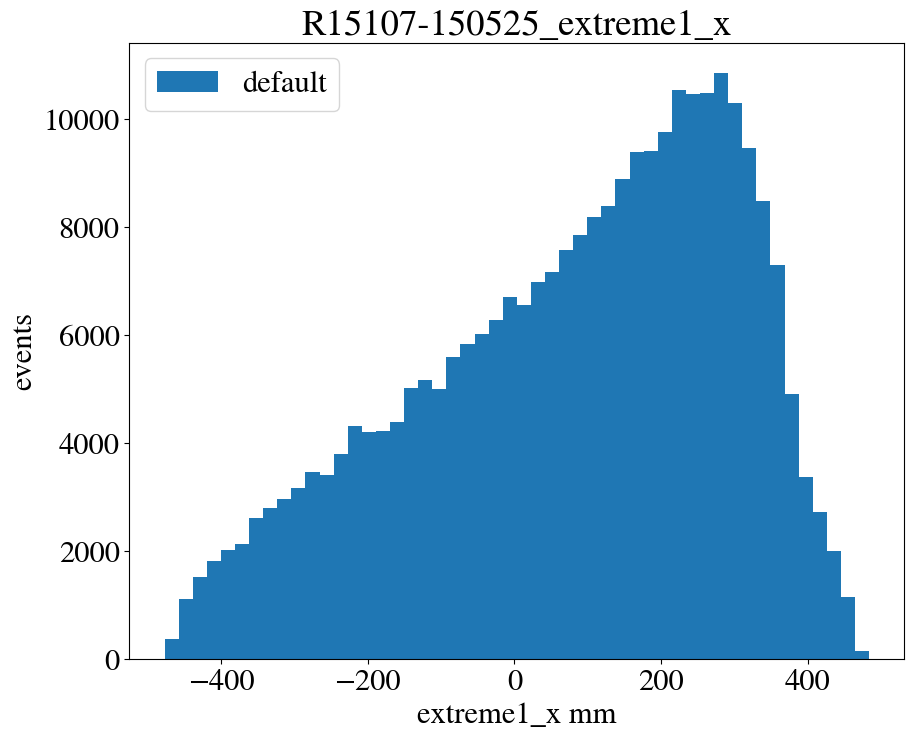

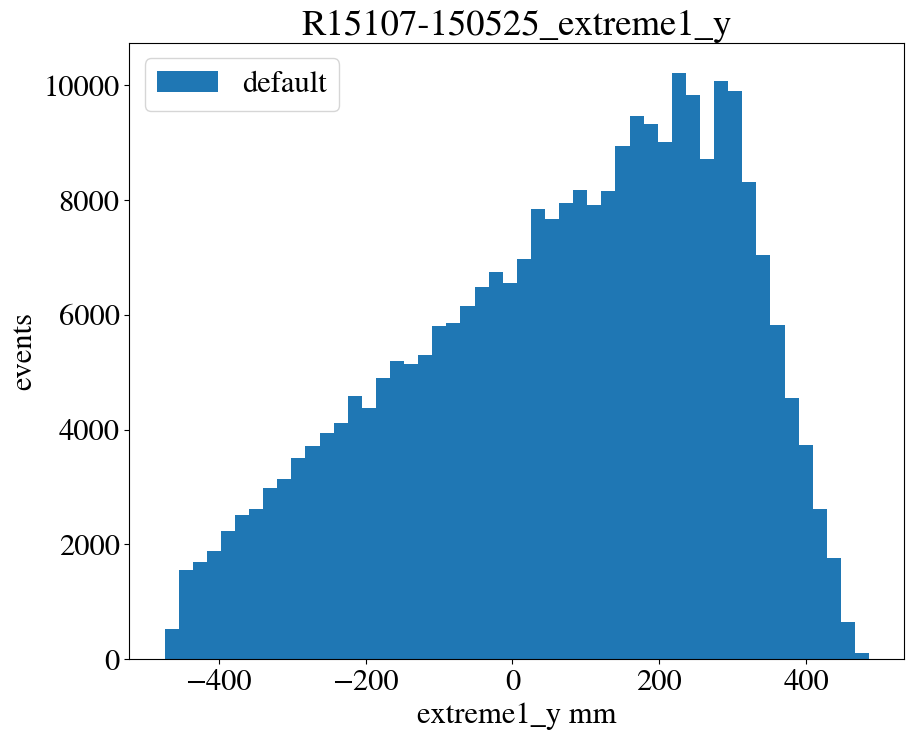

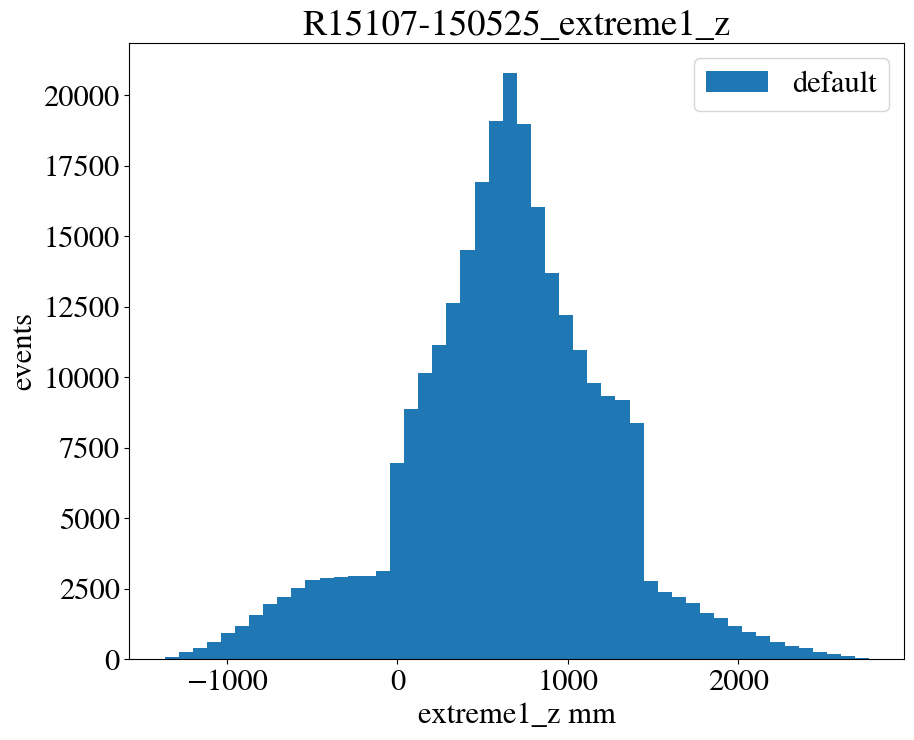

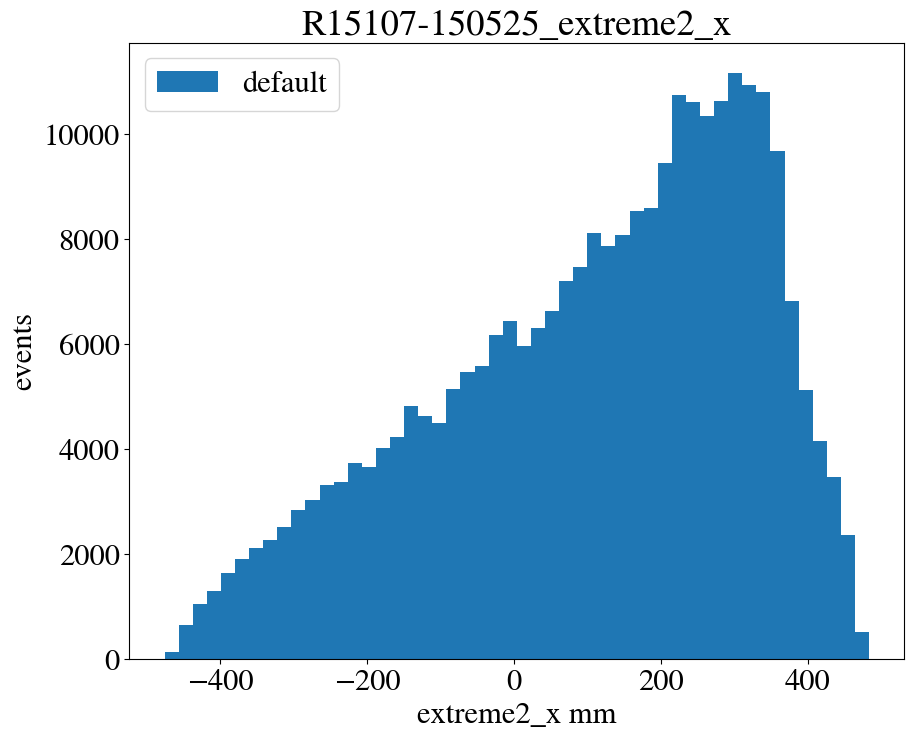

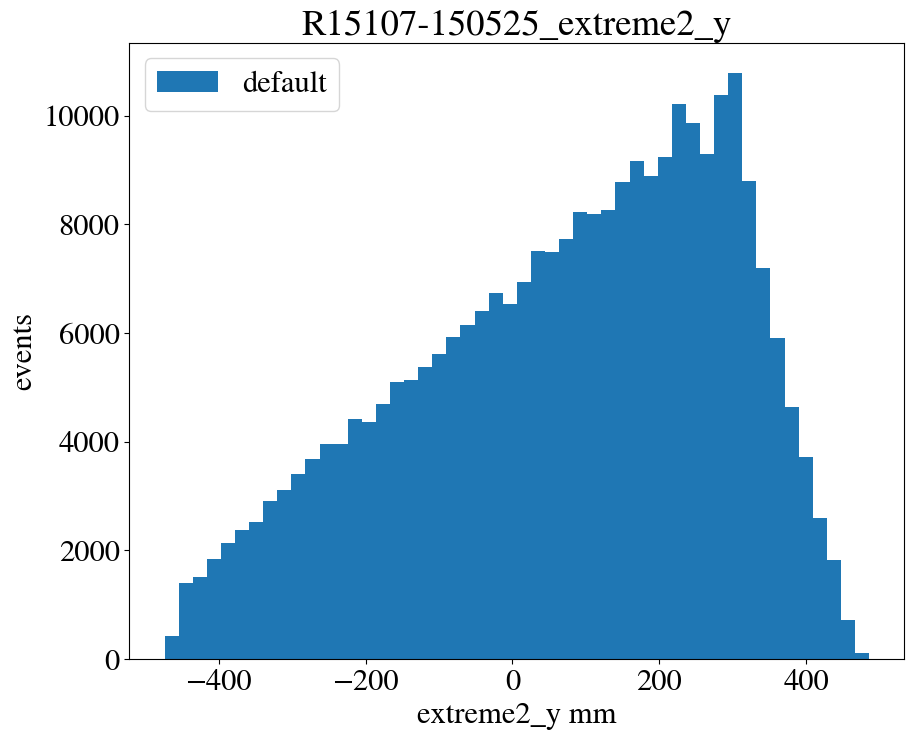

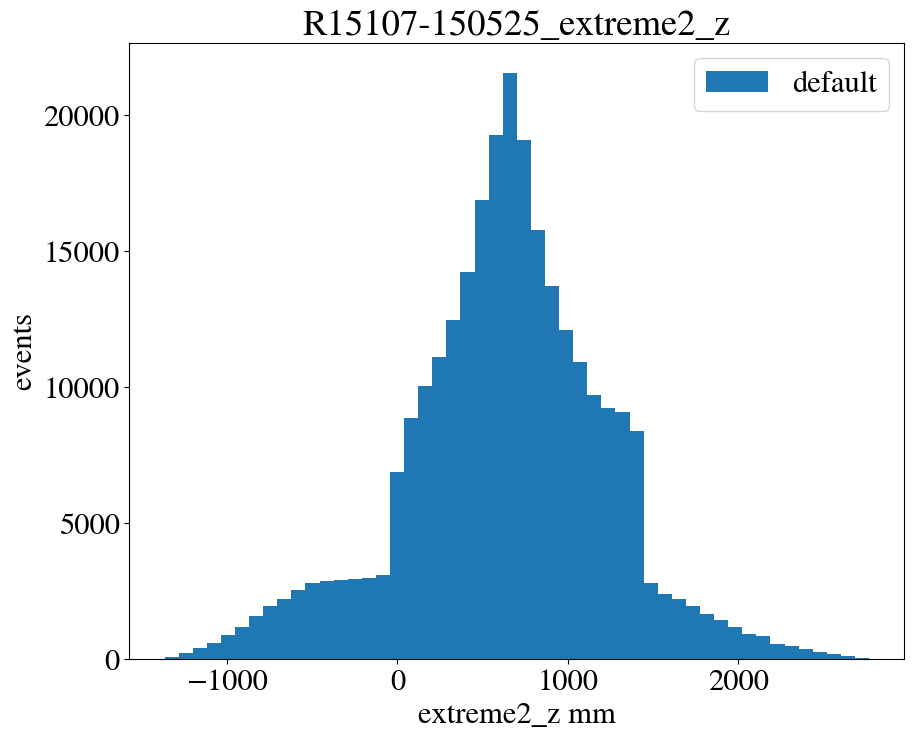

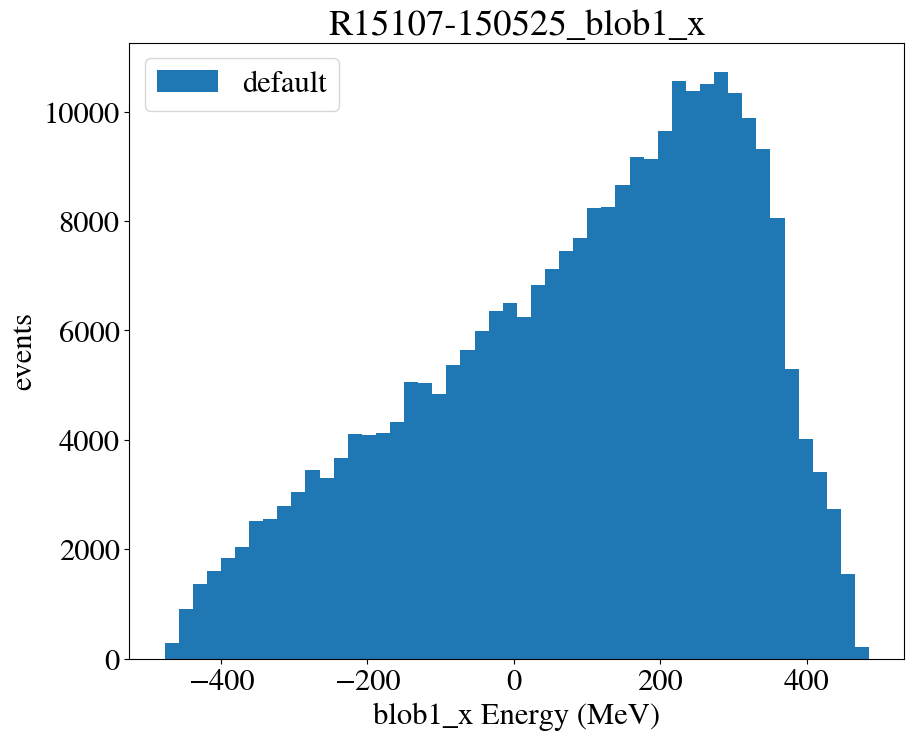

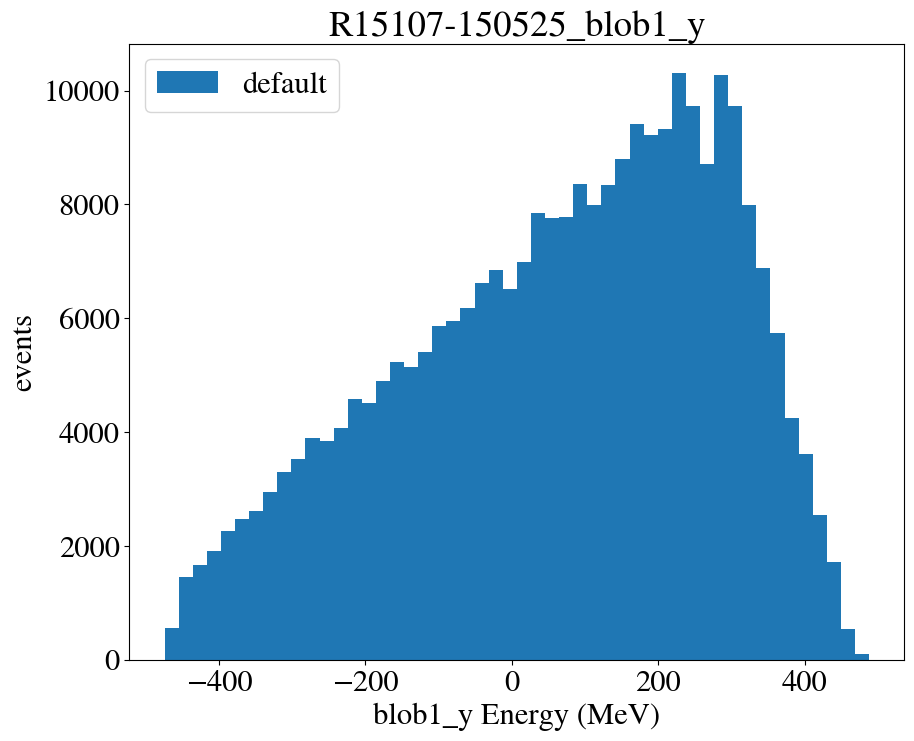

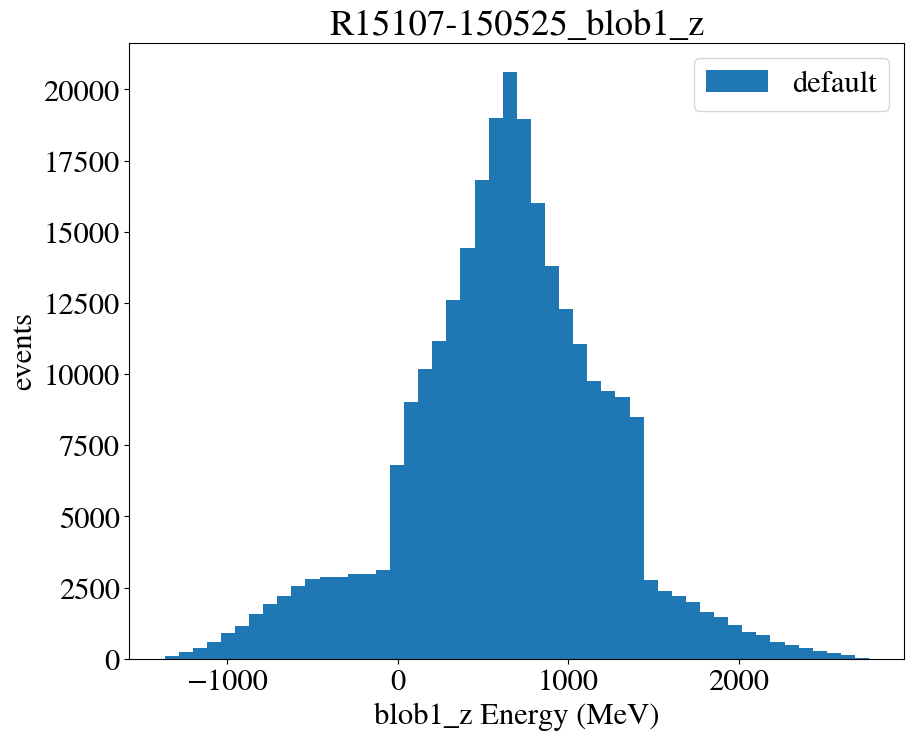

In [62]:
for vars, labels in zip(blob_vars, blob_labels):
    func.plot_hist( hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}blob/')

# apply cuts and plot the same things

In [ ]:
#######################################################################################
#########################   CUT PARAMETERS   #####################################
#######################################################################################
low_z = 20
upp_z  = 1195
r_lim = 415
low_e = 1.5
upp_e = 1.7

In [64]:
cut_hdst, efficiencies = func.apply_cuts(hdst, 
                                         lower_z = low_z, 
                                         upper_z = upp_z, 
                                         r_lim   = r_lim, 
                                         lower_e = low_e, 
                                         upper_e = upp_e)

display(efficiencies)

Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Fiducial track cut
Relative Cut efficiency:
Efficiency: 52.06 %
Absolute Cut efficiency:
Efficiency: 52.06 %
One track cut
Relative Cut efficiency:
Efficiency: 49.09 %
Absolute Cut efficiency:
Efficiency: 29.74 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 50.32 %
Absolute Cut efficiency:
Efficiency: 15.72 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.52 %
Absolute Cut efficiency:
Efficiency: 6.74 %


Cut  Relative Efficiency  Relative Events  \
0            No cuts           100.000000           102902   
1      Fiducial Cuts            52.055354            53566   
2      One track cut            49.092708            26297   
3  Blob overlap cuts            50.317527            13232   
4        Energy cuts            10.519952             1392   

   Single Cut Efficiency  
0             100.000000  
1              52.055354  
2              29.741890  
3              15.722726  
4               6.744281

# And plot again

disable the `log_flag` for low statistics

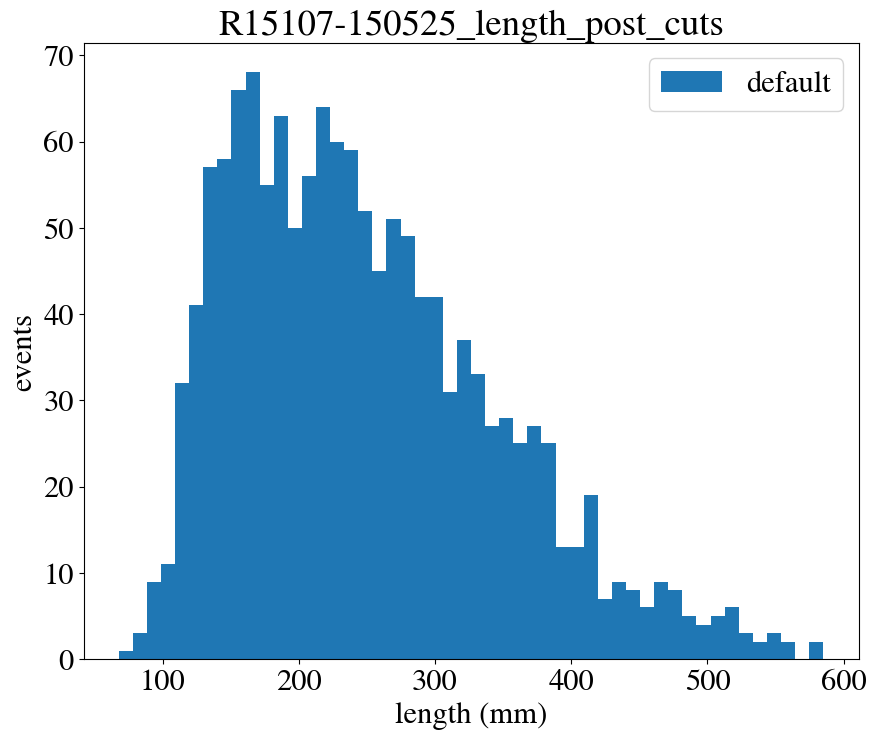

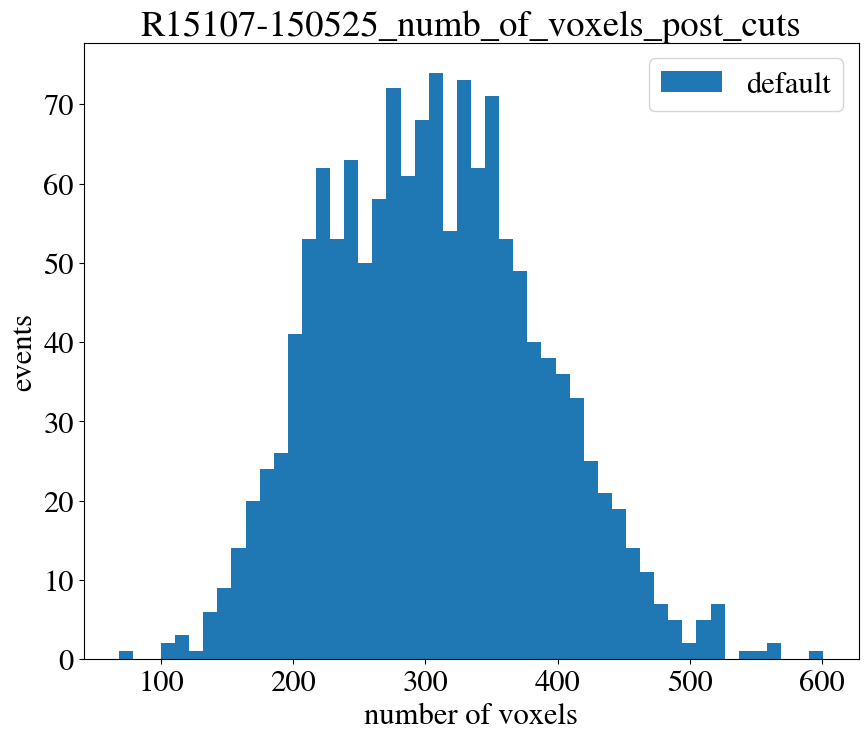

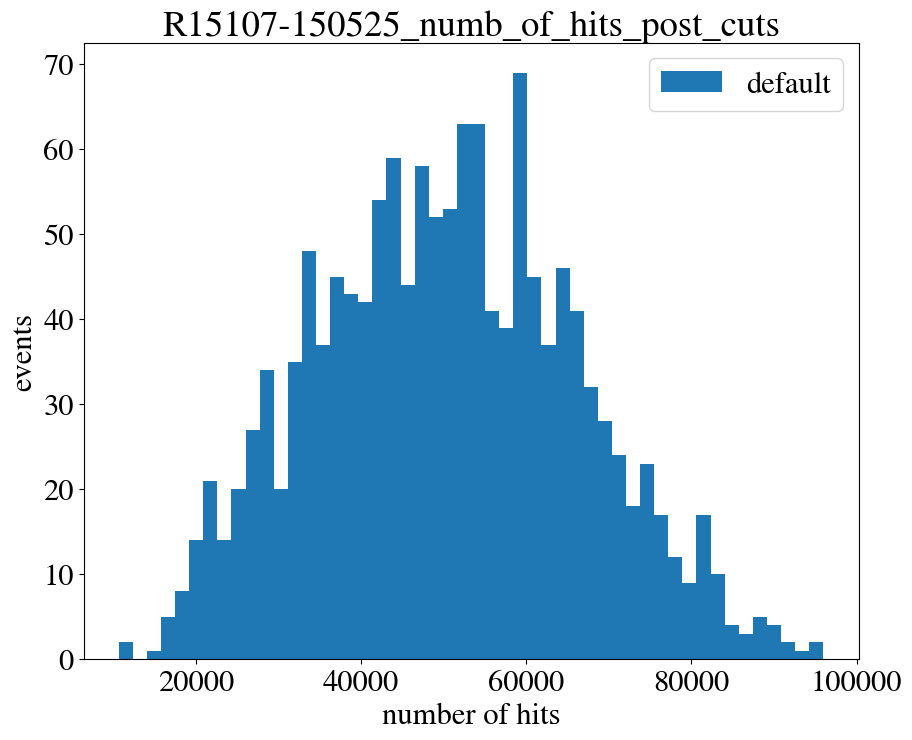

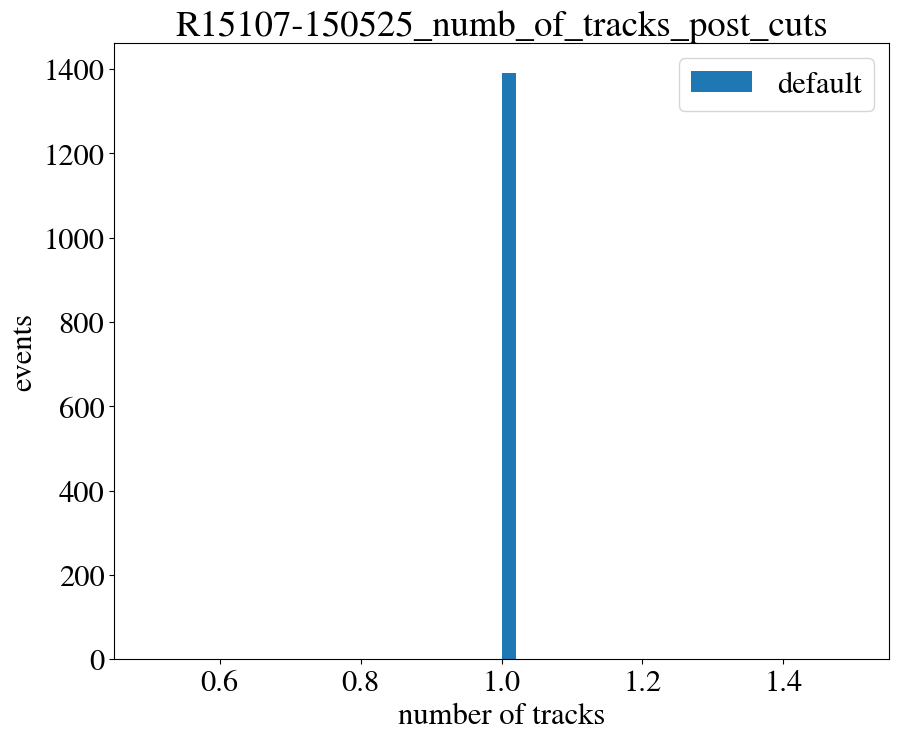

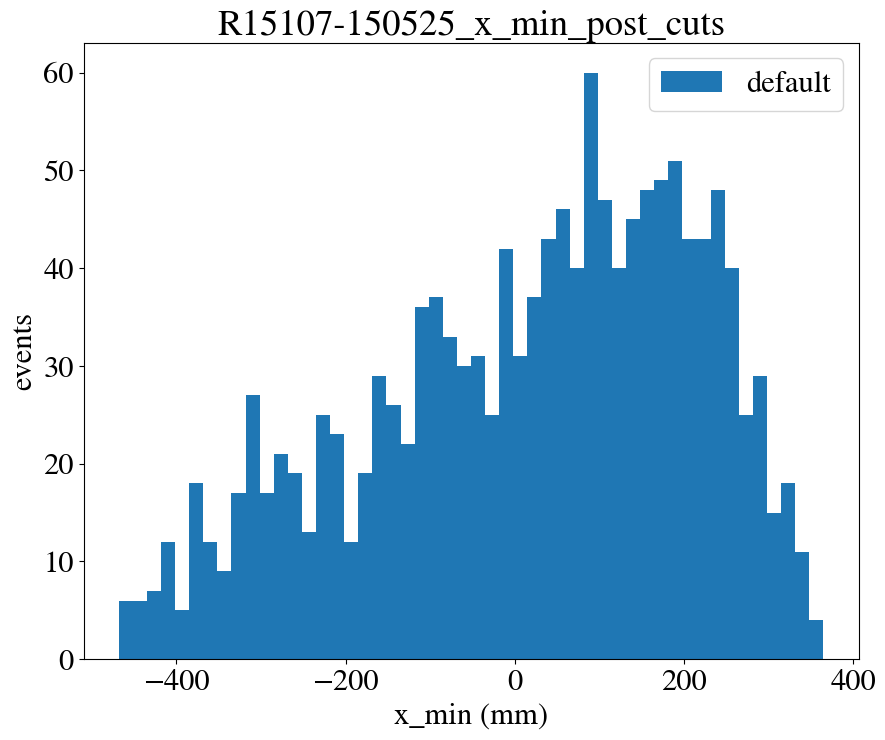

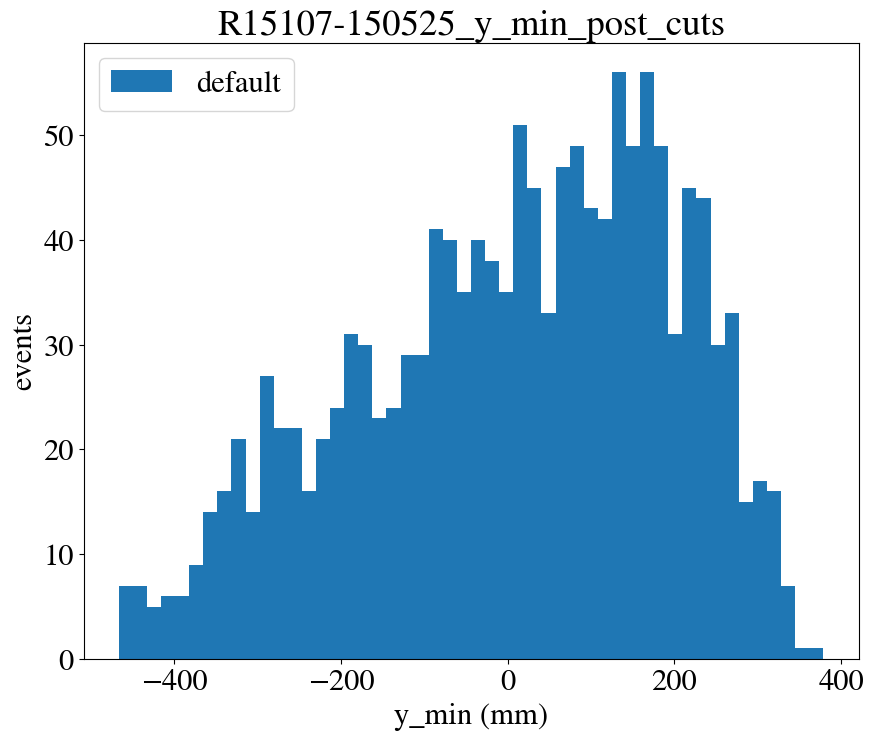

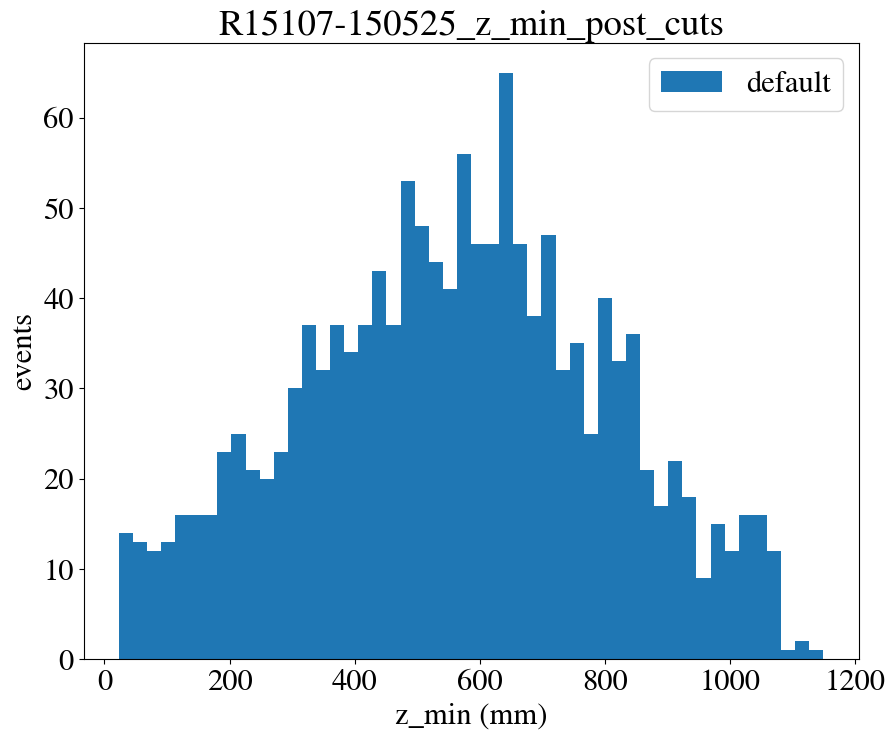

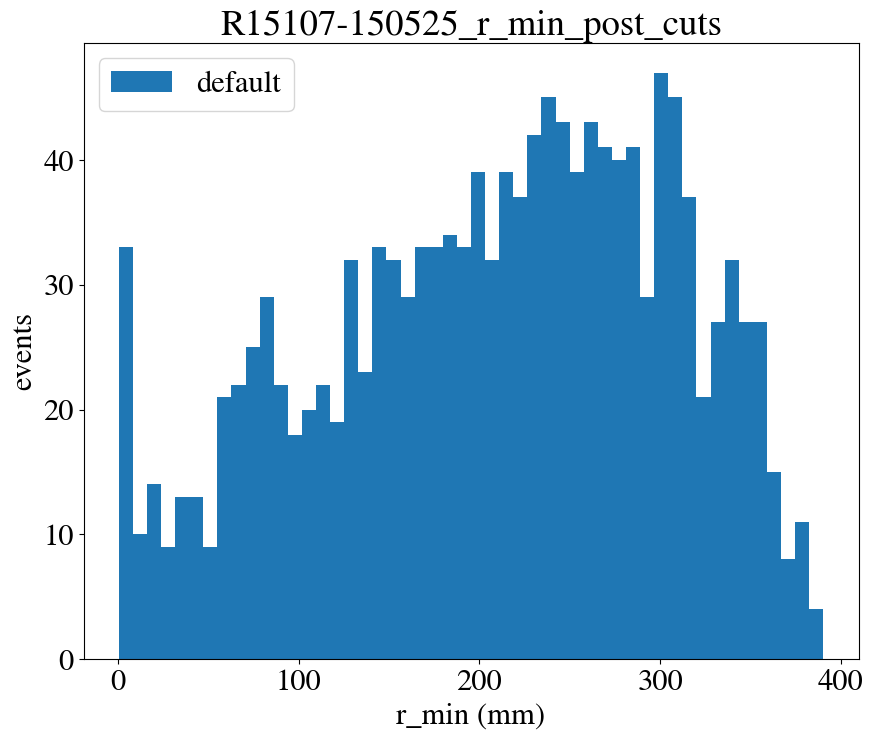

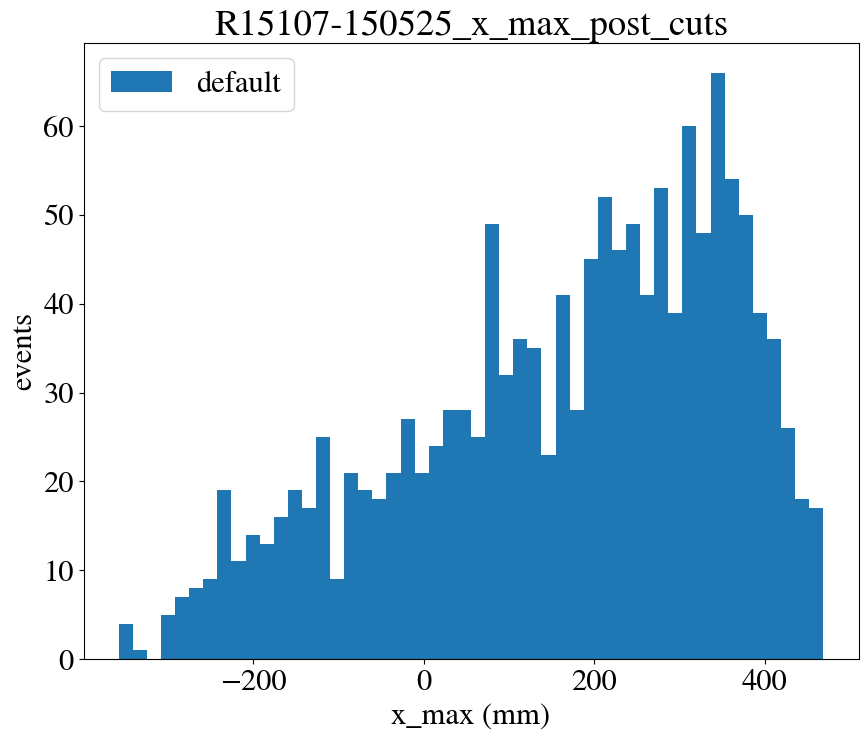

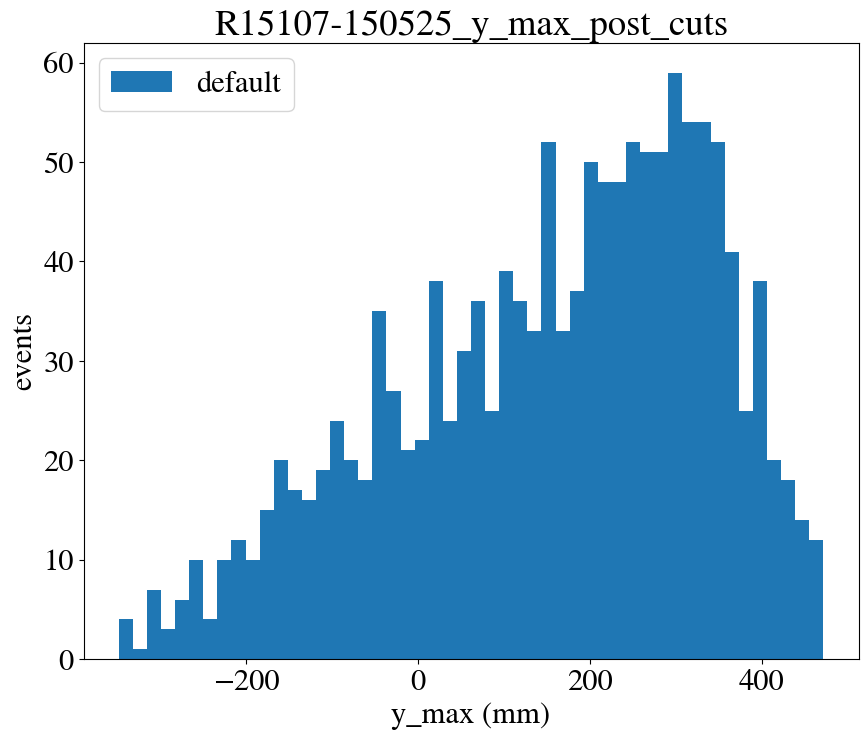

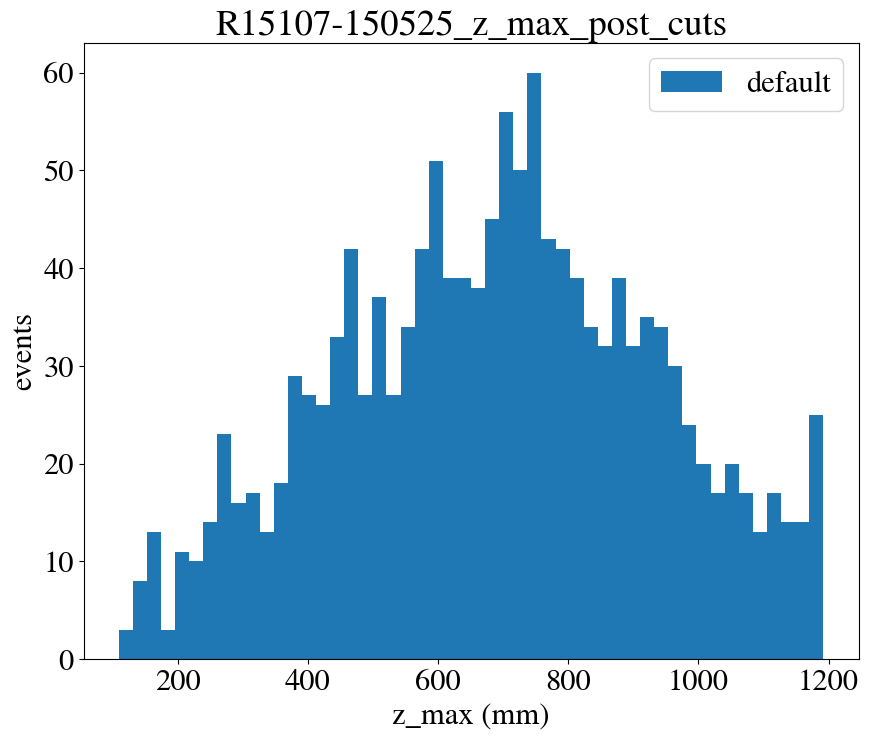

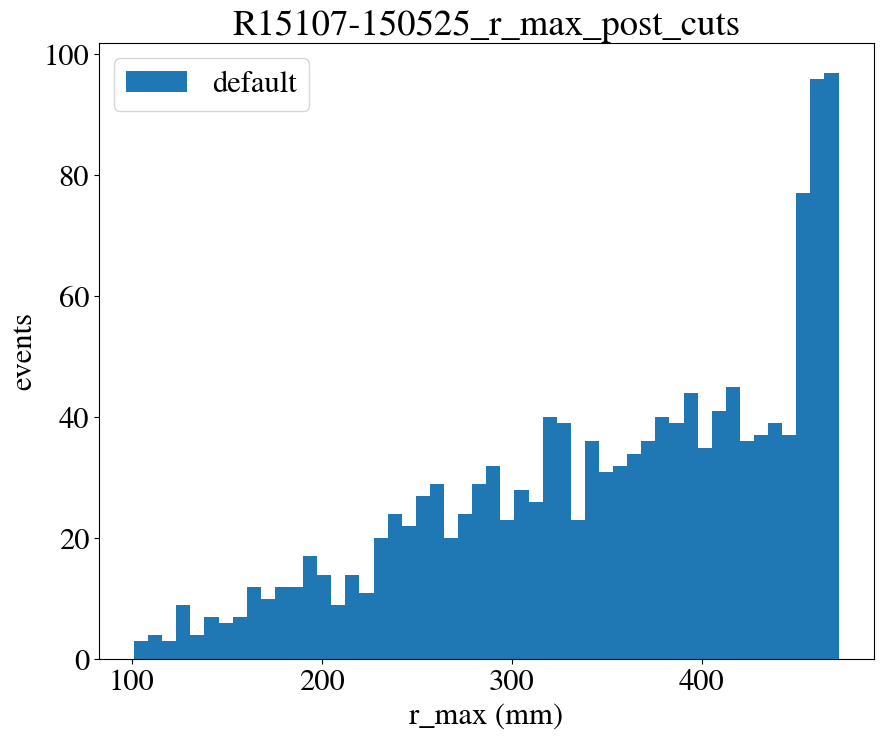

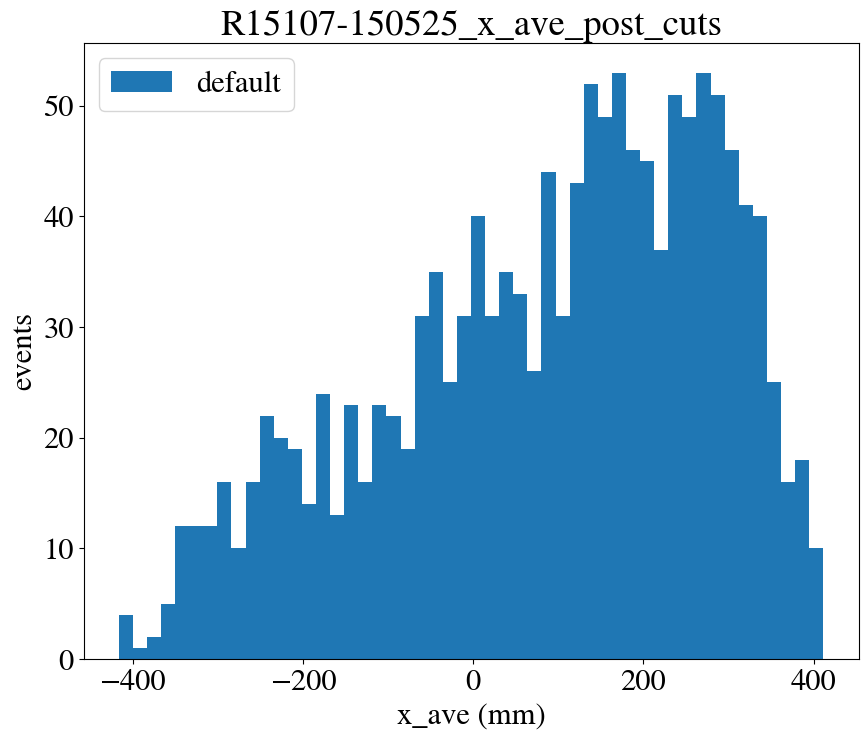

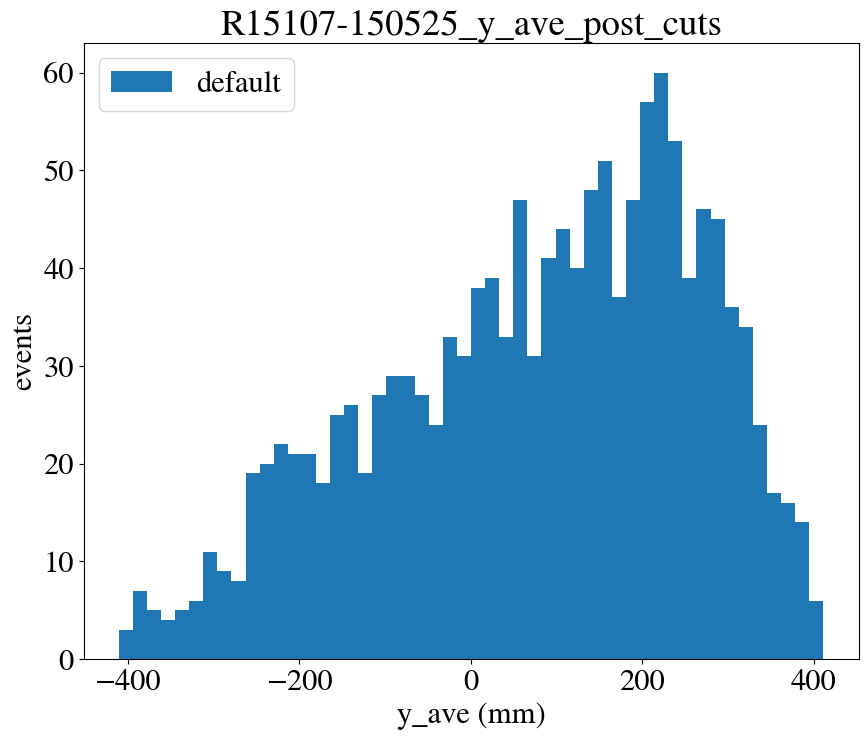

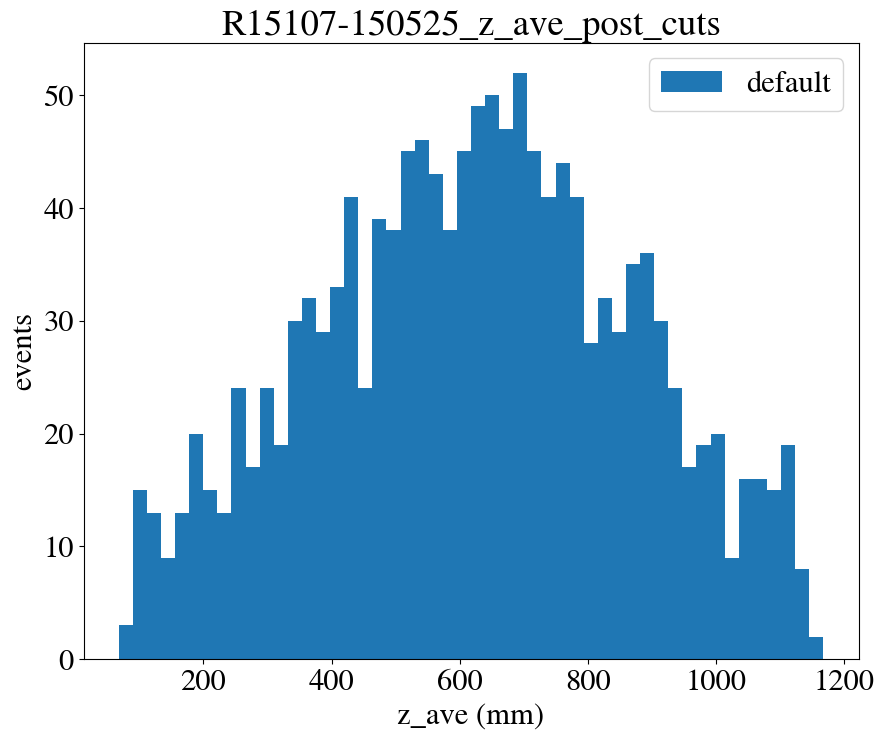

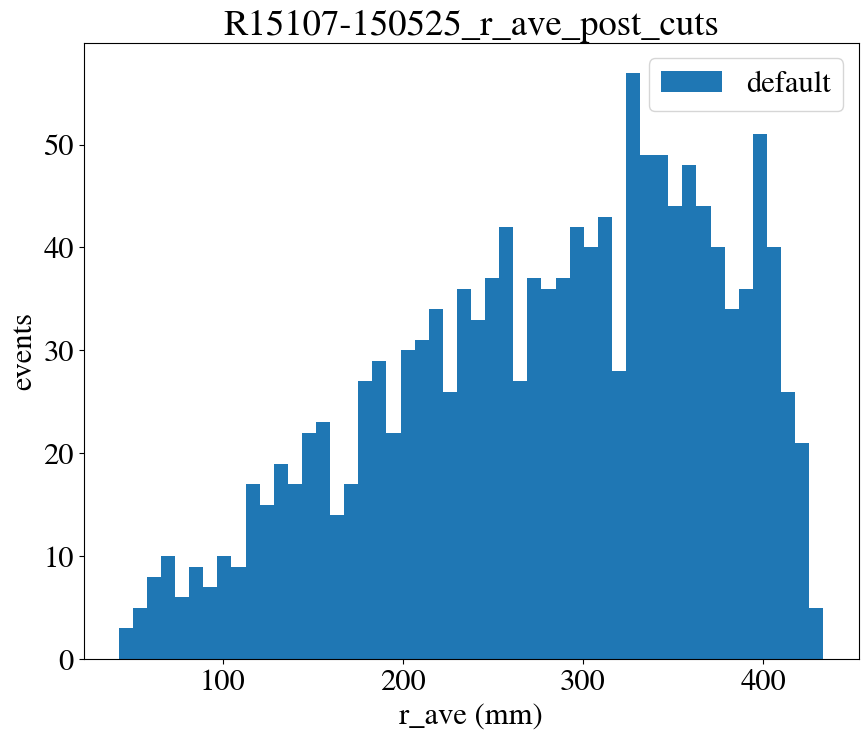

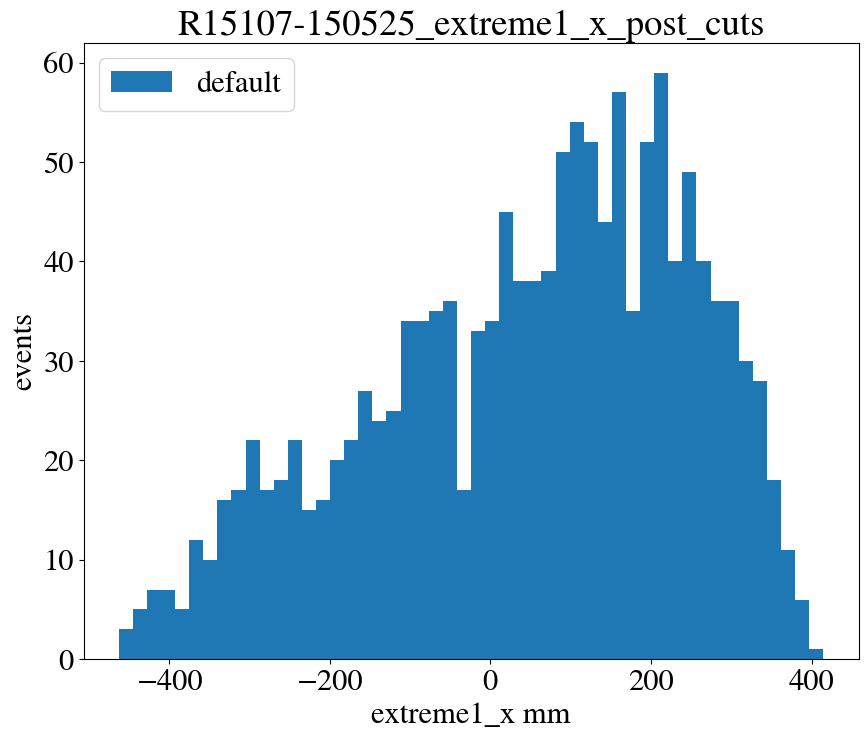

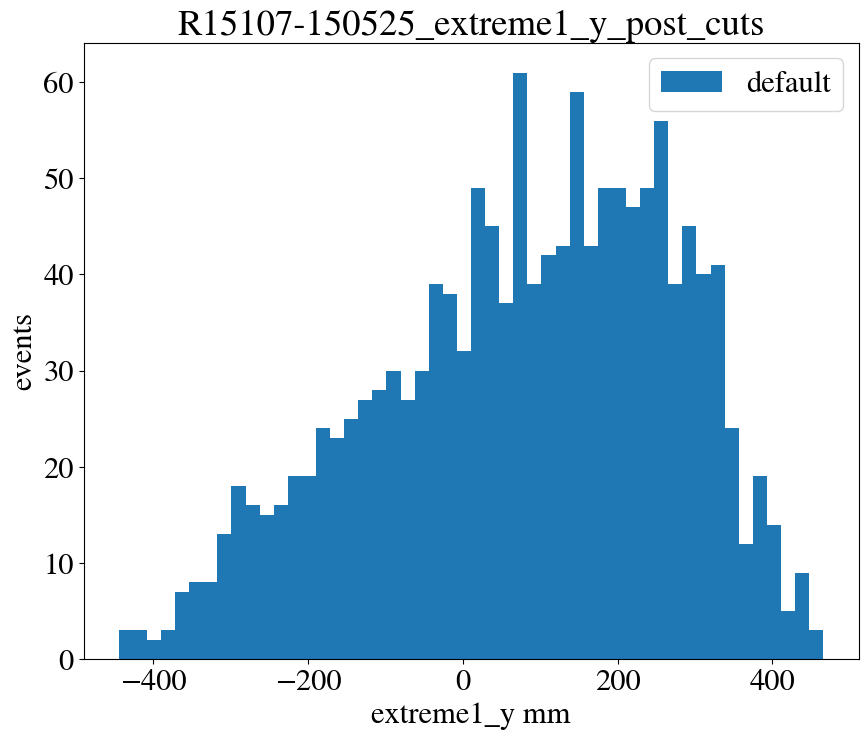

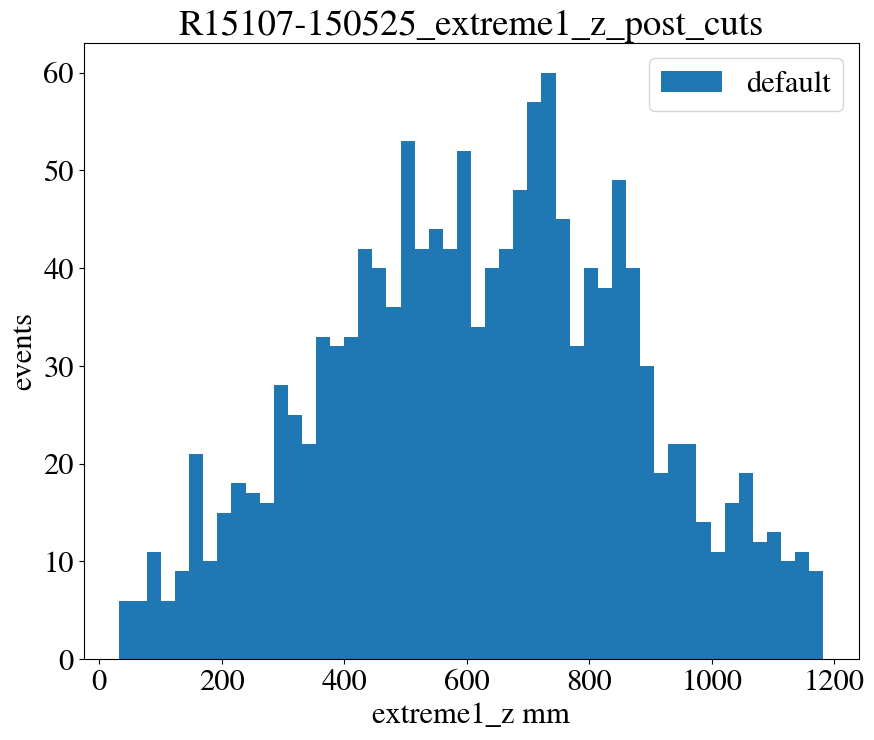

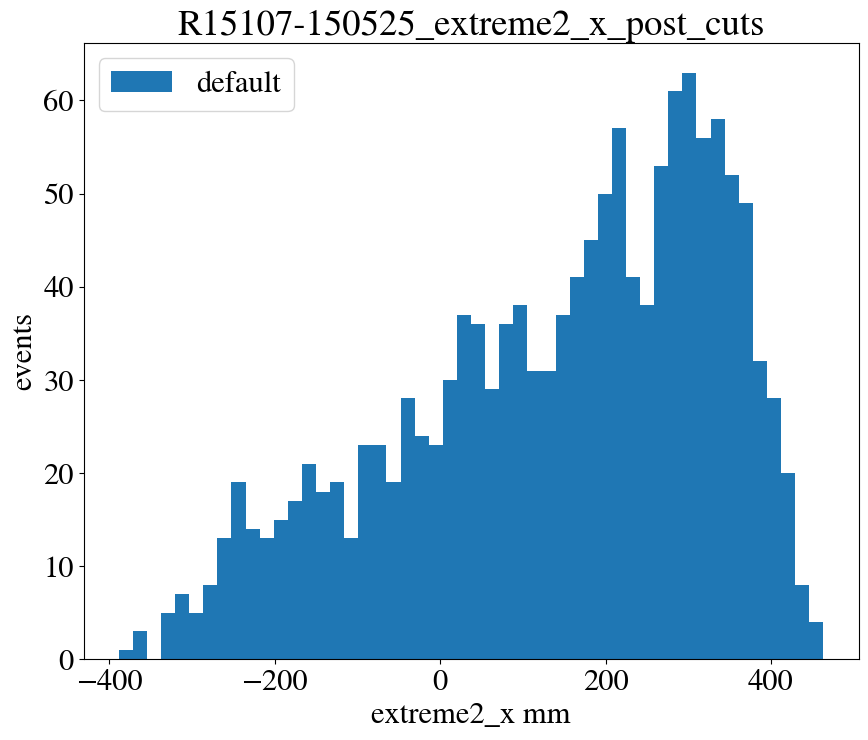

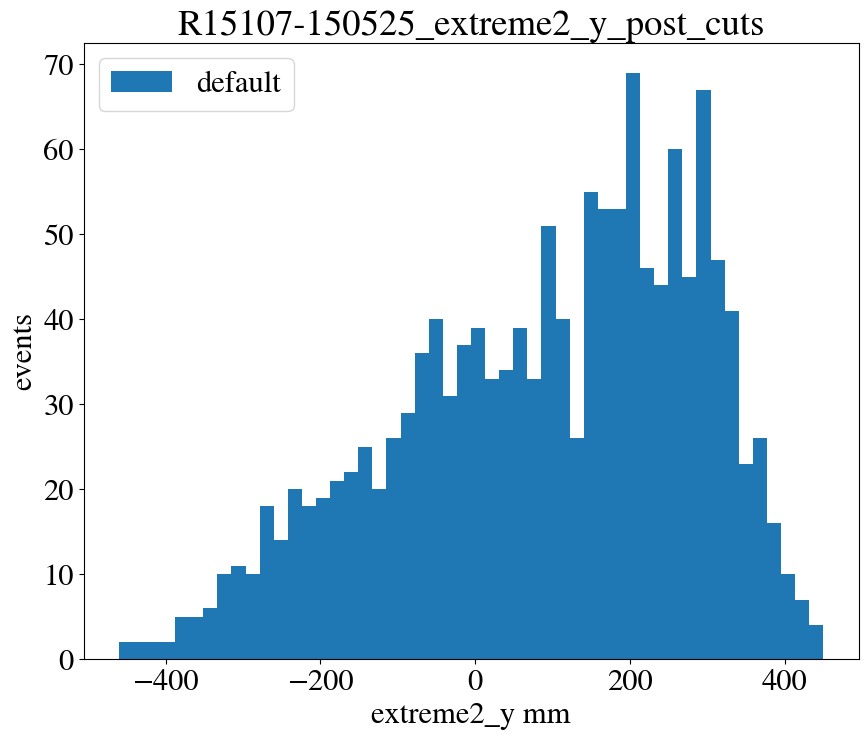

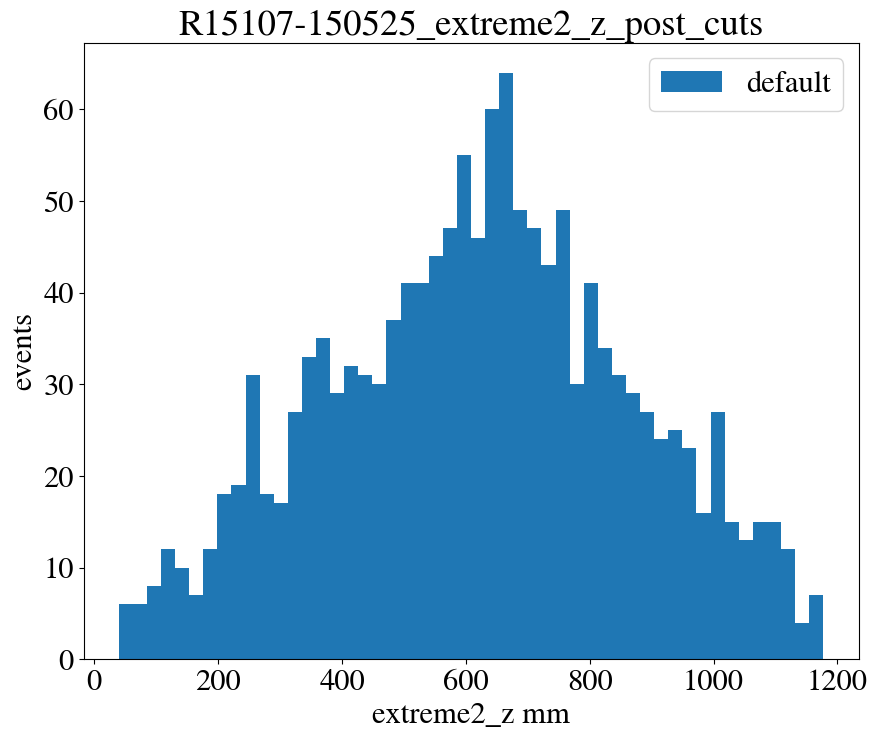

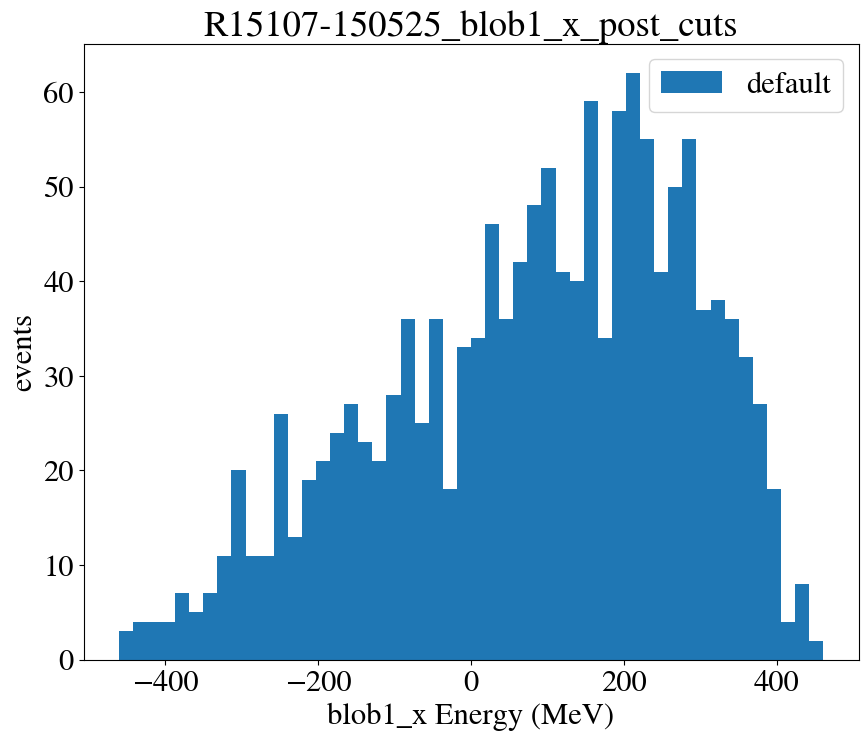

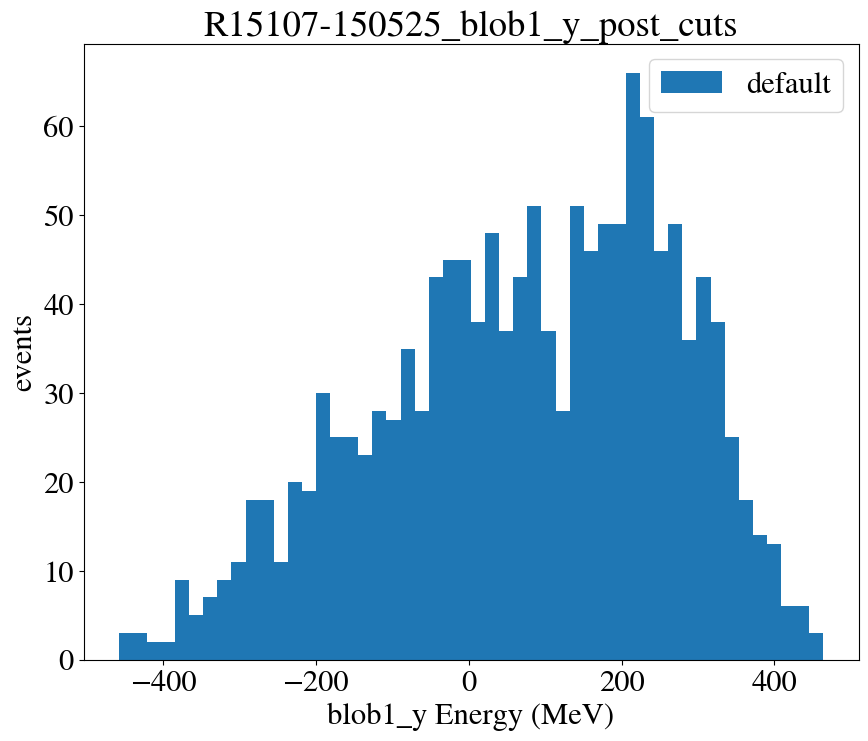

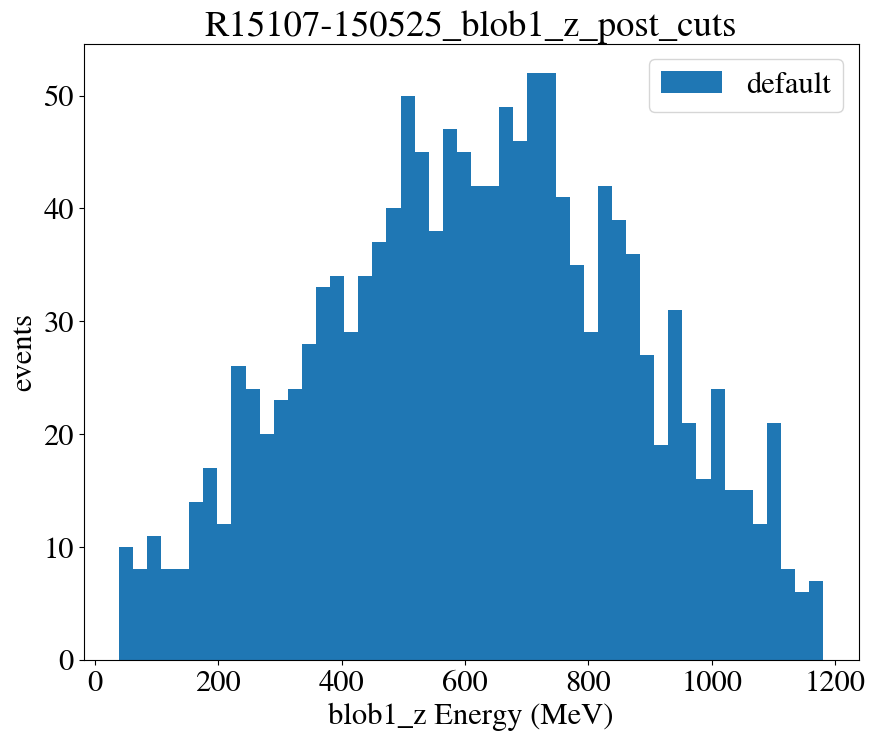

In [65]:
log_flag = False
#############################################################
##################### TOPOLOGICAL ###########################
#############################################################

for vars, labels in zip(top_vars, top_labels):
    func.plot_hist( cut_hdst
                  , vars
                  , binning  = 50
                  , title    = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_cuts'
                  , x_label  = f'{labels}'
                  , outliers = (0, 99.99999)
                  , log      = log_flag
                  , output   = True
                  , save     = True
                  , save_dir = f'{folder_name}topology/')
    

#############################################################
###################### GEOMETRIC ############################
#############################################################

for vars, labels in zip(geo_vars, geo_labels):
    func.plot_hist( cut_hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_cuts'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}geometry/')
    
for vars, labels in zip(blob_vars, blob_labels):
    func.plot_hist( cut_hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_cuts'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}blob/')

# look at satellites here

Maximal number of tracks: 0        1
1        9
2        9
3        9
4        9
        ..
39777    2
39778    2
39779    2
39780    1
39781    1
Name: numb_of_tracks, Length: 276234, dtype: int64


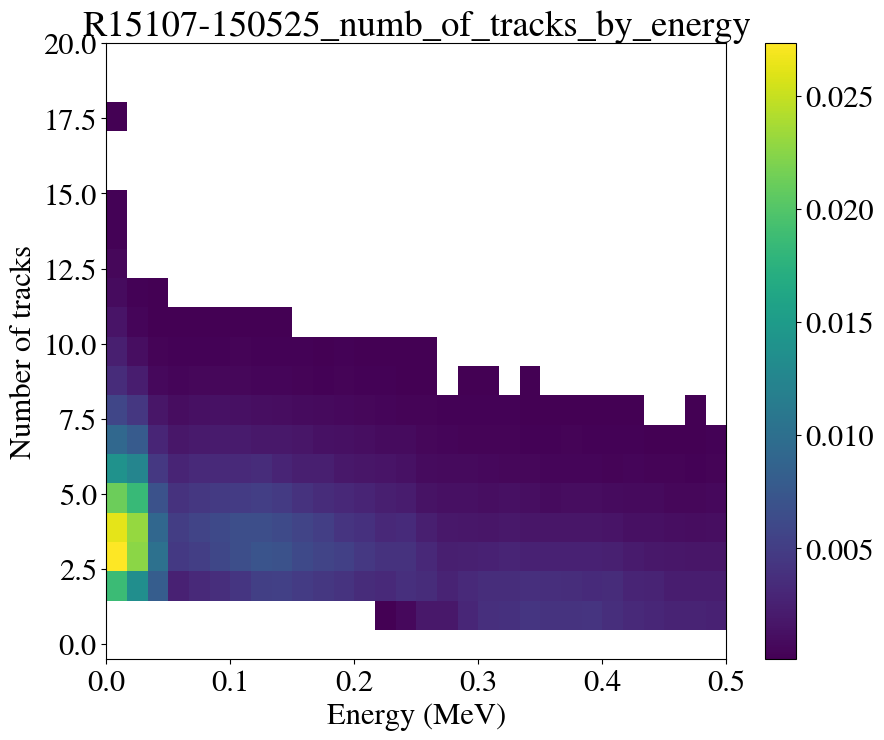

In [66]:
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

track_energy = hdst.energy
track_no = hdst.numb_of_tracks
# normalise
print(f'Maximal number of tracks: {track_no}')
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
#plt.hist2d(track_energy, track_no, weights = weights, bins=(30, 21), cmin=0.0001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(30, 21), cmin=0.0001, range = ((0,0.5),(-0.5,20)))
title_trck_num = f'R{RUN_NUMBER}-{TIMESTAMP}_numb_of_tracks_by_energy'
plt.title(f'{title_trck_num}')
plt.colorbar()
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.savefig(f'{folder_name}energy/{title_trck_num}.png')
plt.show()

# And blob 1 blob 2 distributions

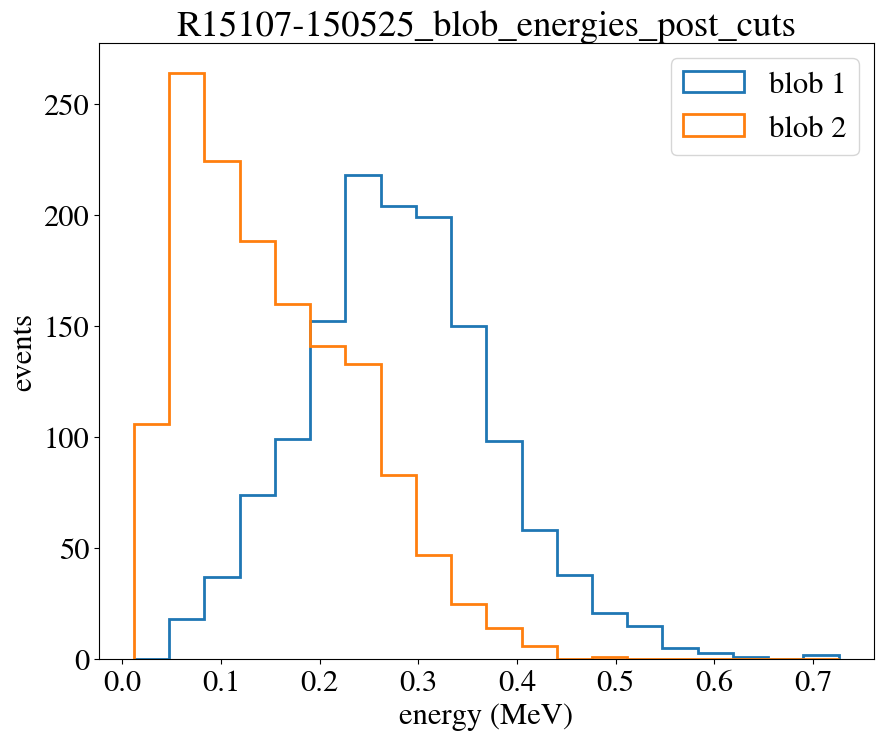

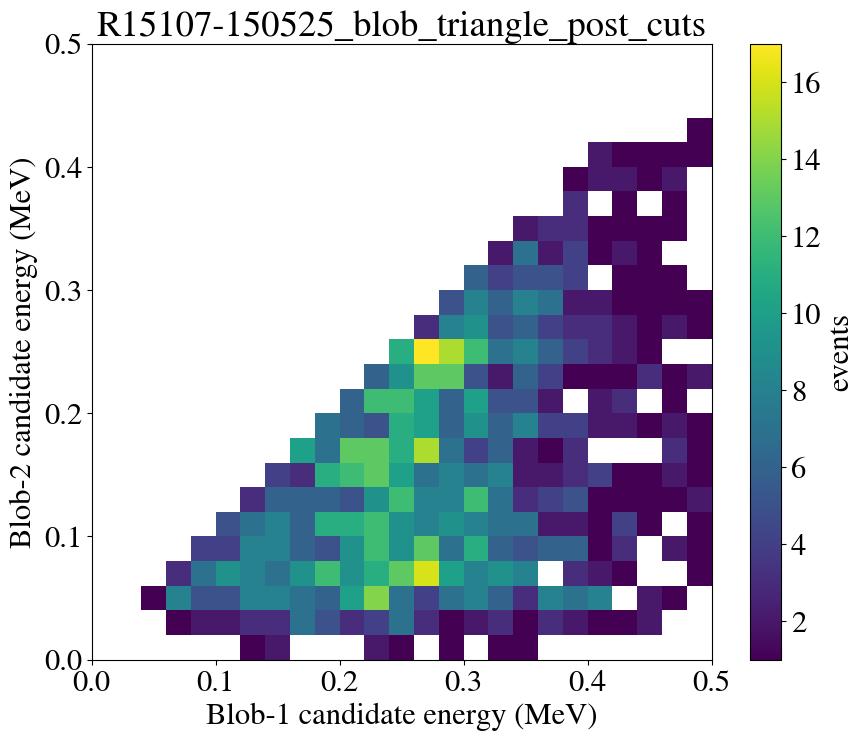

In [67]:
blob_title        = f'R{RUN_NUMBER}-{TIMESTAMP}_blob_energies_post_cuts'
blob_2dhits_title = f'R{RUN_NUMBER}-{TIMESTAMP}_blob_triangle_post_cuts'
# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(cut_hdst['eblob1'].to_numpy())
eblob_full.append(cut_hdst['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)

func.plot_hist(cut_hdst, column = 'eblob1', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
func.plot_hist(cut_hdst, column = 'eblob2', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
plt.savefig(f'{folder_name}blob/{blob_title}.png')
plt.legend()
plt.show()

# blob 2dhist
plt.hist2d(cut_hdst['eblob1'], cut_hdst['eblob2'], bins=(25, 25), range=((0, 0.5), (0, 0.5)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title(f'{blob_2dhits_title}')
plt.savefig(f'{folder_name}blob/{blob_2dhits_title}.png')
plt.show()

# cut by cut plots

### fiducial track cut

In [68]:
fid_hdst = func.fiducial_track_cut_2( hdst
                                    , lower_z = low_z
                                    , upper_z = upp_z
                                    , r_lim   = r_lim)

_ = func.cut_effic(fid_hdst, hdst, verbose = True)

Efficiency: 52.06 %
Events in reduced dataframe: 101655
Events in initial dataframe: 276234


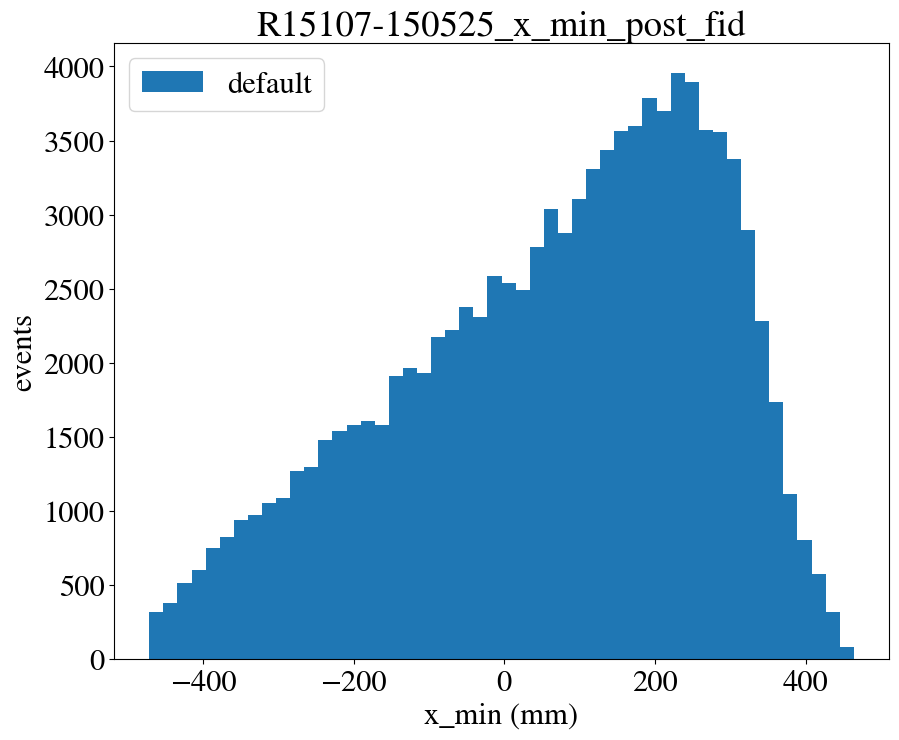

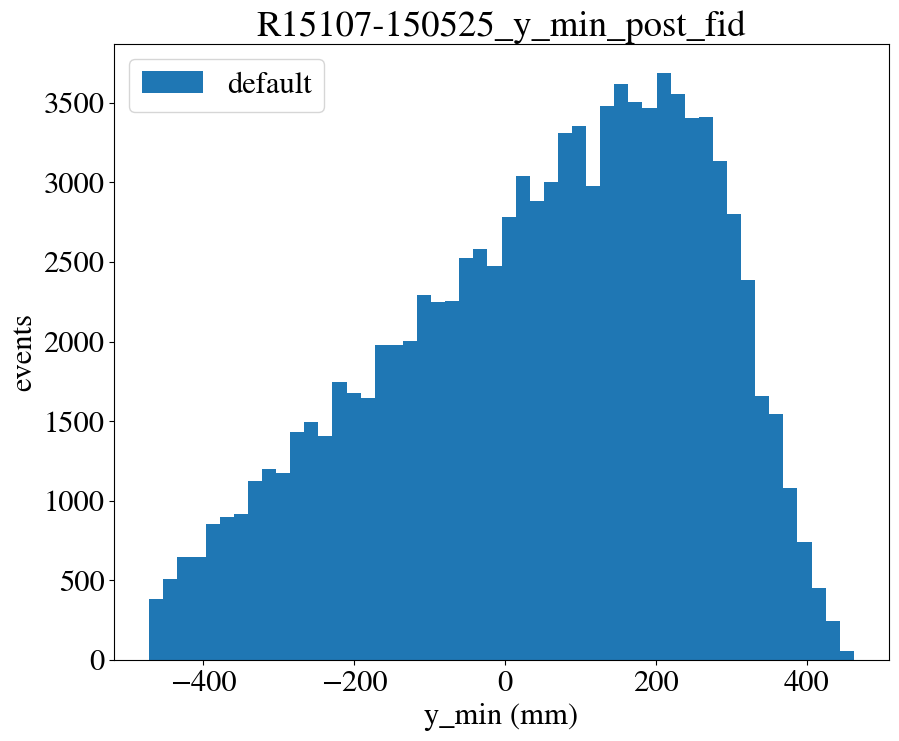

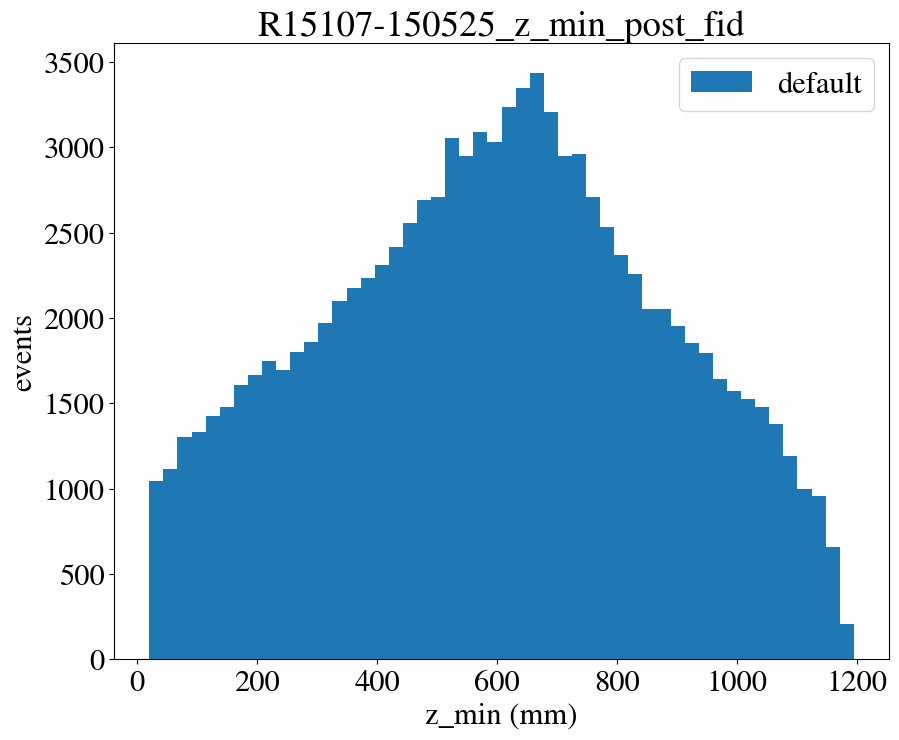

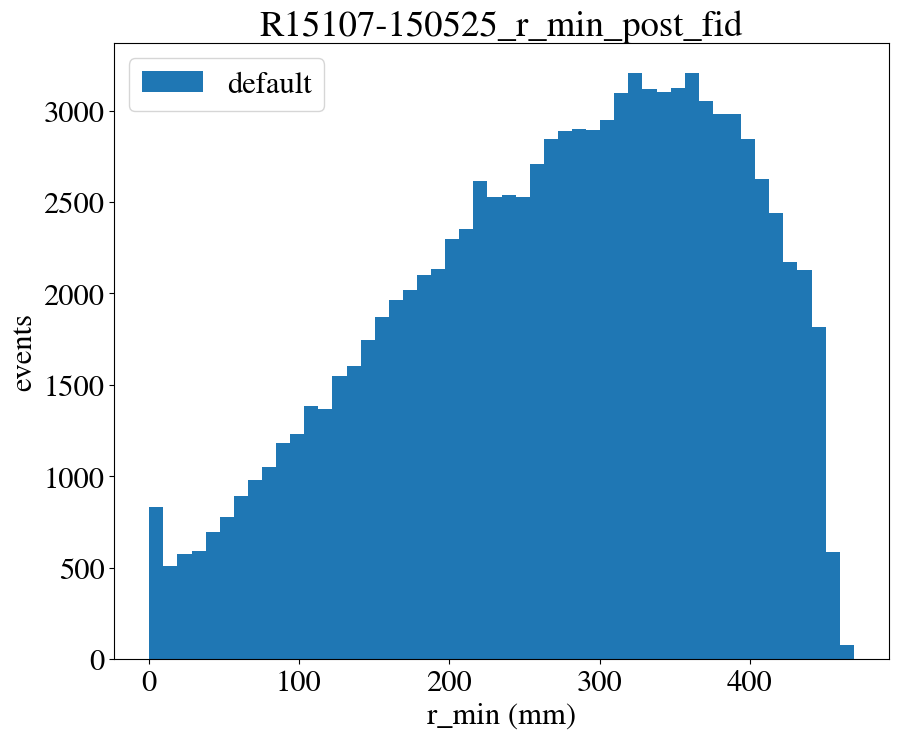

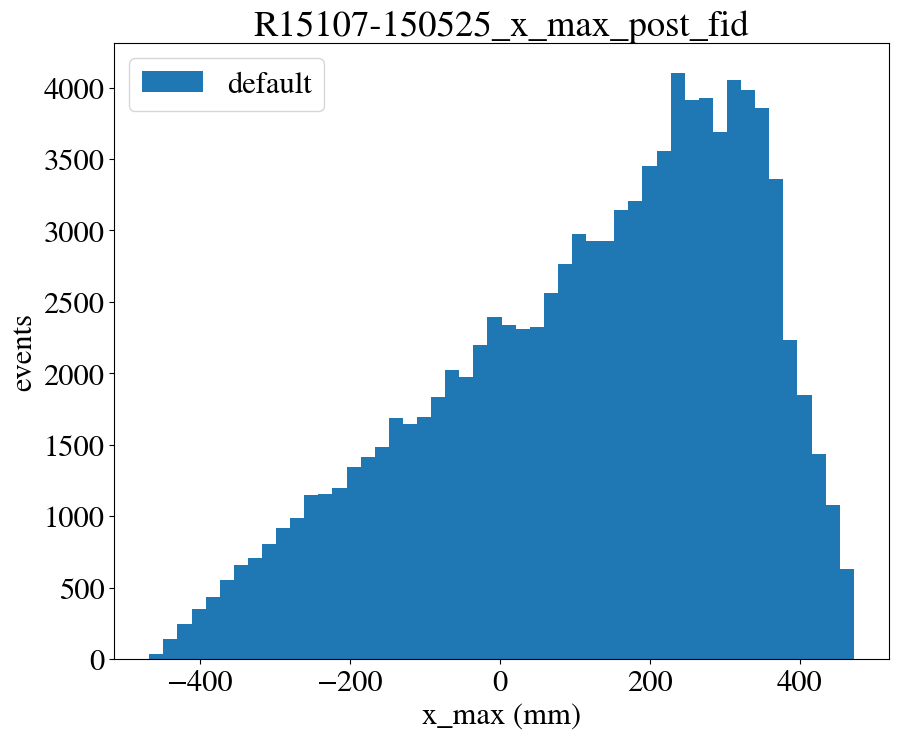

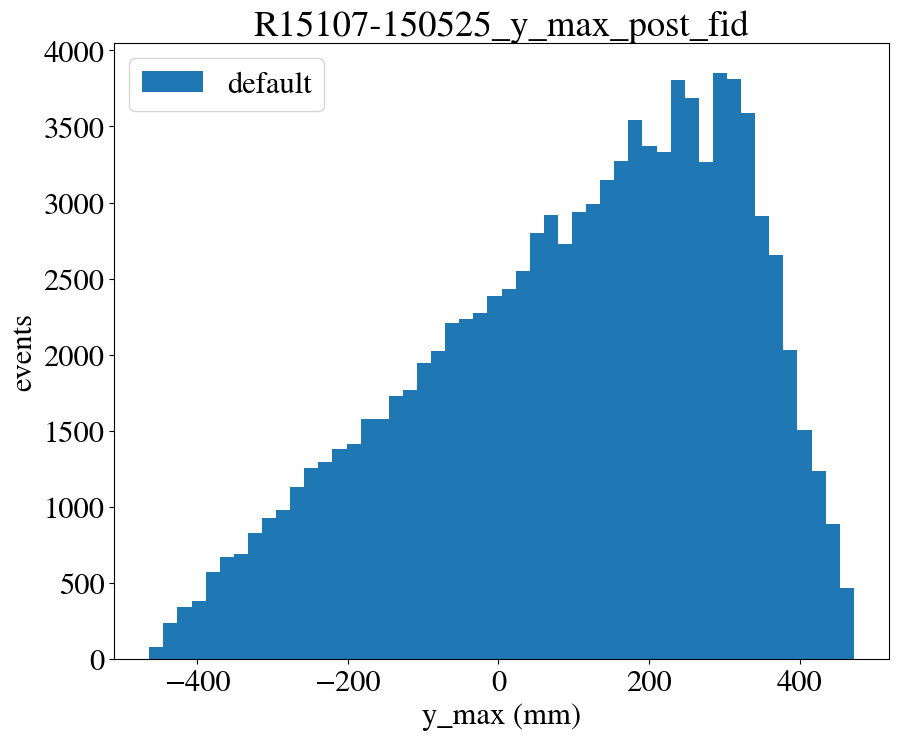

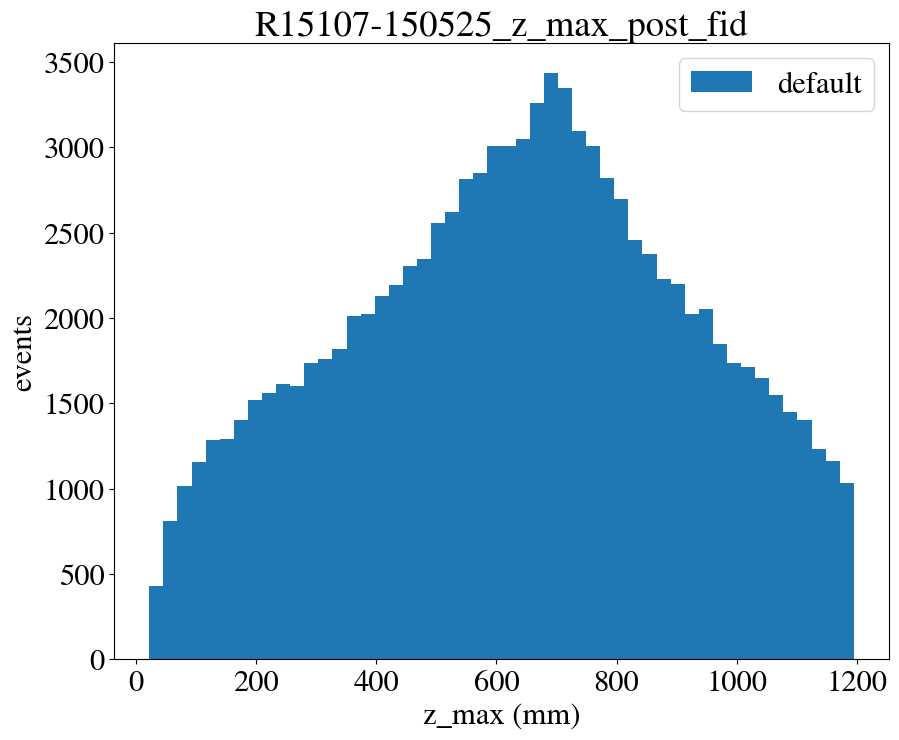

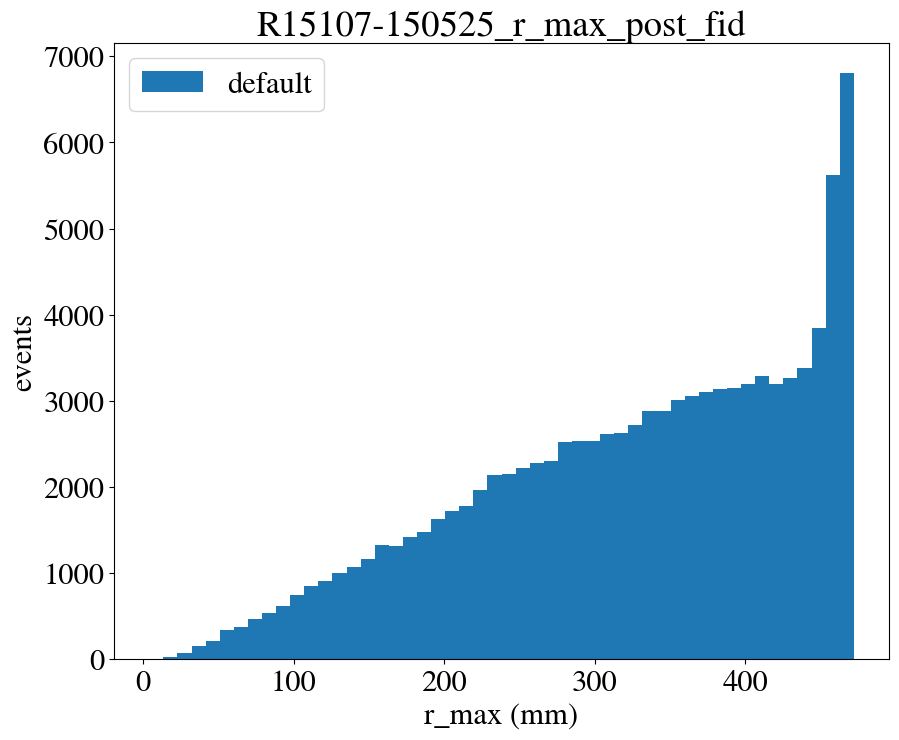

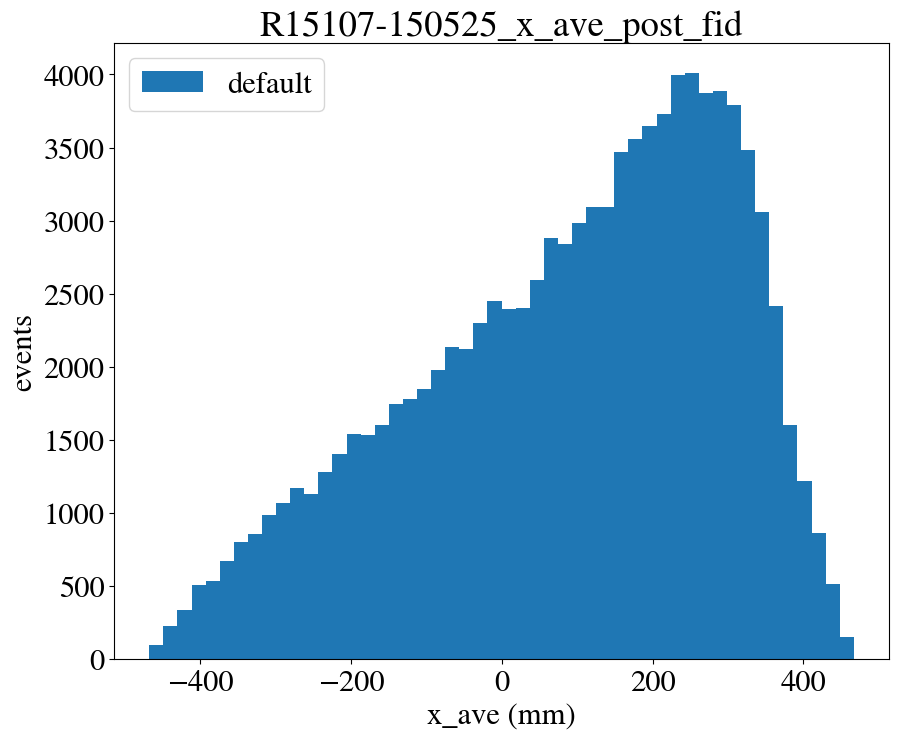

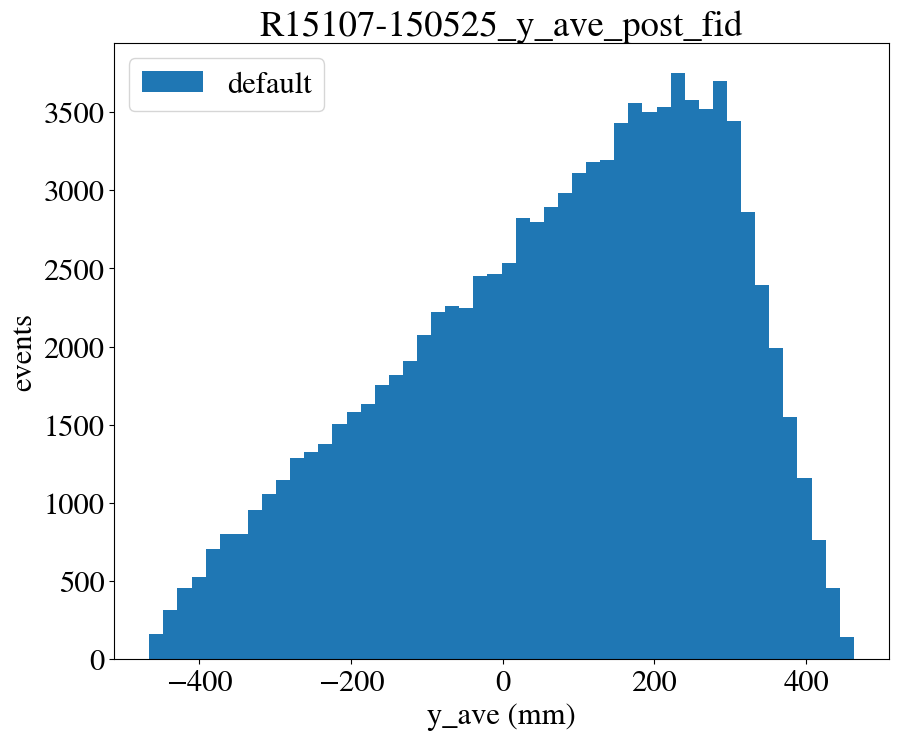

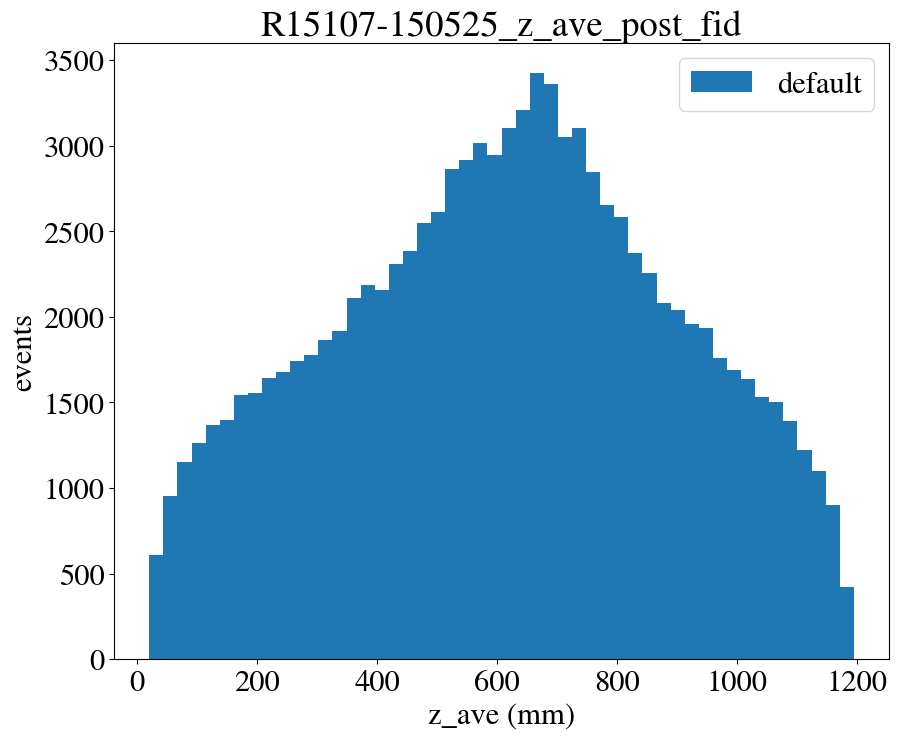

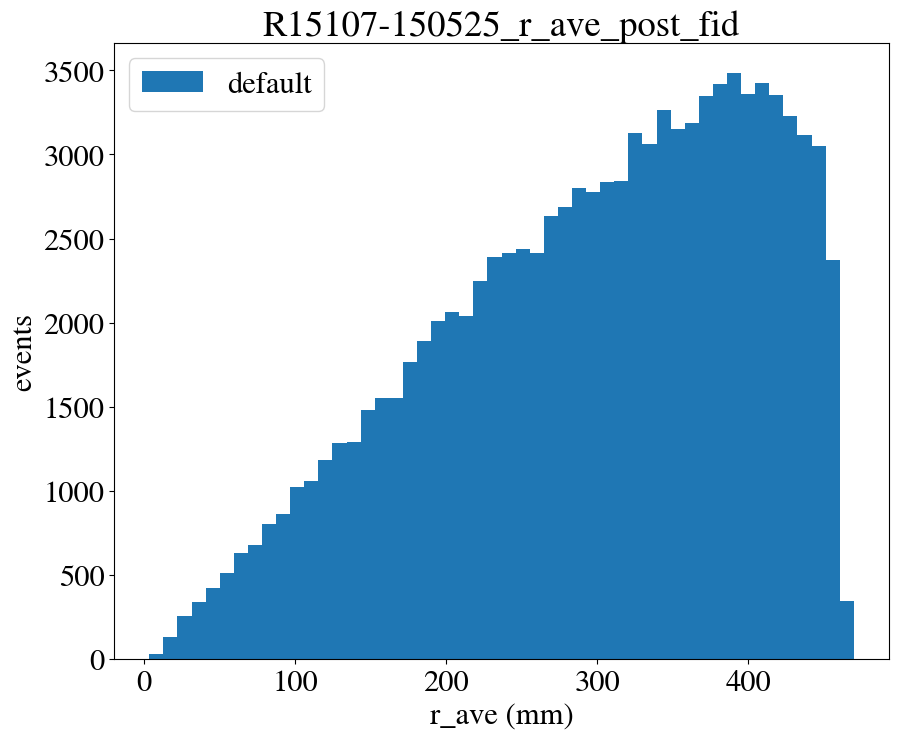

In [69]:
#############################################################
###################### GEOMETRIC ############################
#############################################################

for vars, labels in zip(geo_vars, geo_labels):
    func.plot_hist( fid_hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_fid'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}geometry/')
    

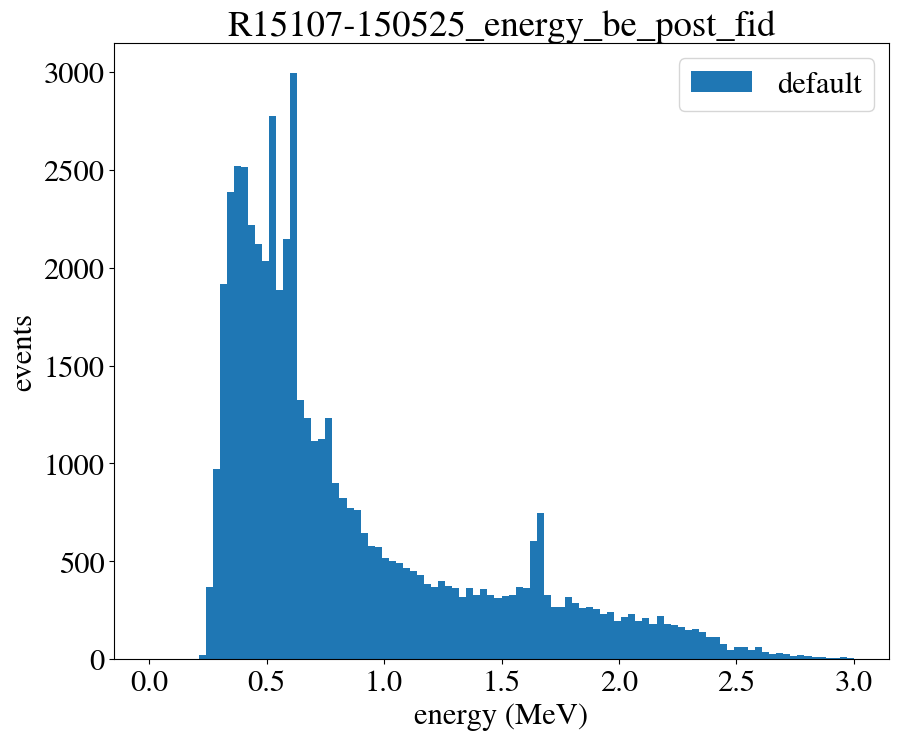

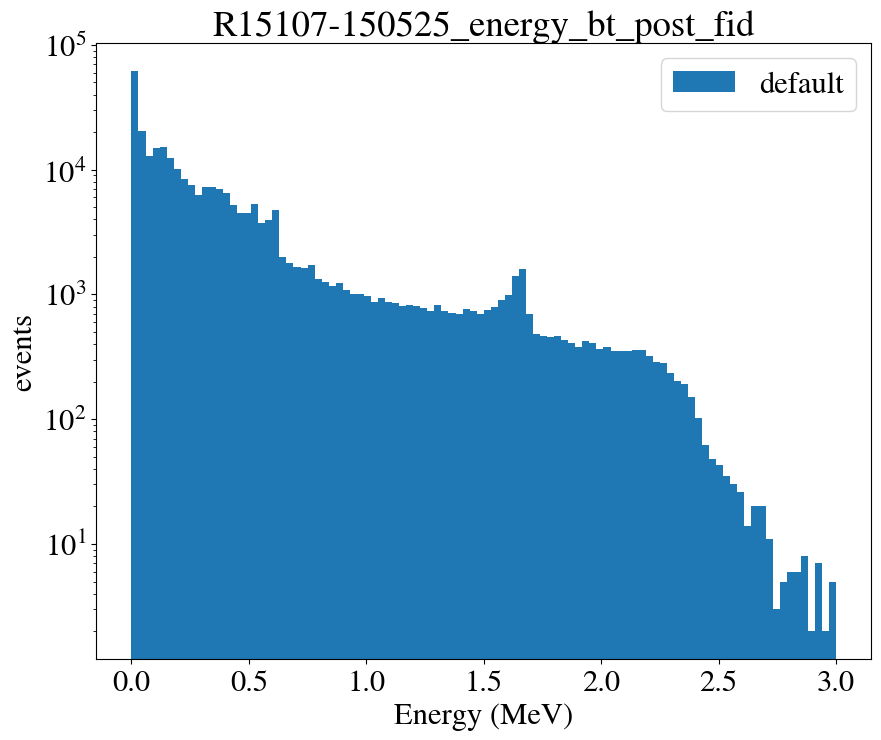

In [70]:
func.plot_hist_over_column(  fid_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_fid'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_fid'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# One track cut

In [71]:
ot_hdst = func.one_track_cuts(fid_hdst)

_ = func.cut_effic(ot_hdst, fid_hdst, verbose = True)

Efficiency: 49.09 %
Events in reduced dataframe: 26297
Events in initial dataframe: 101655


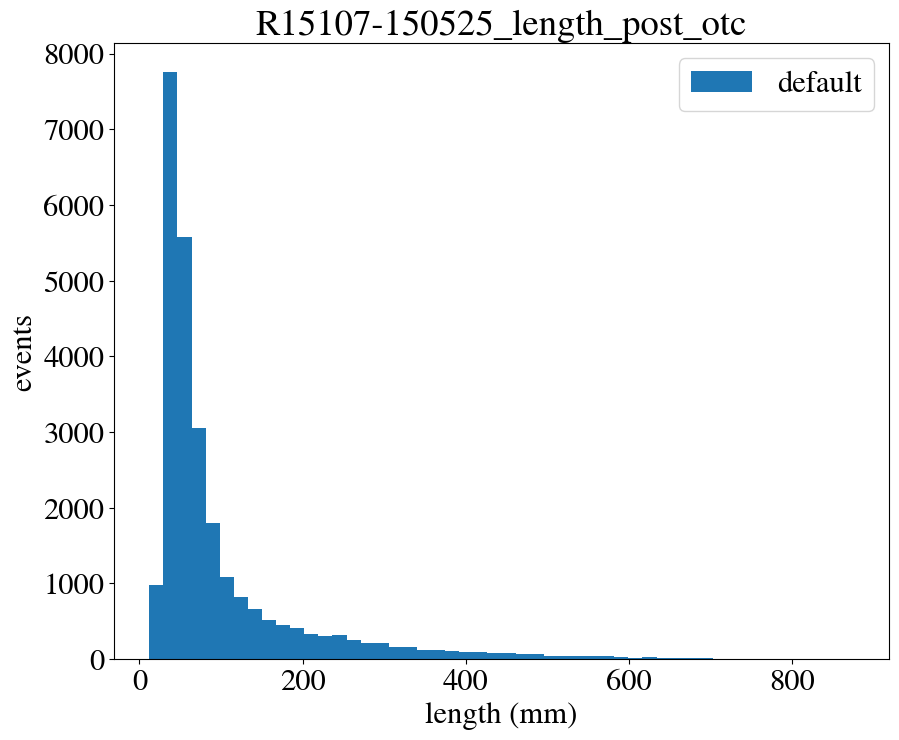

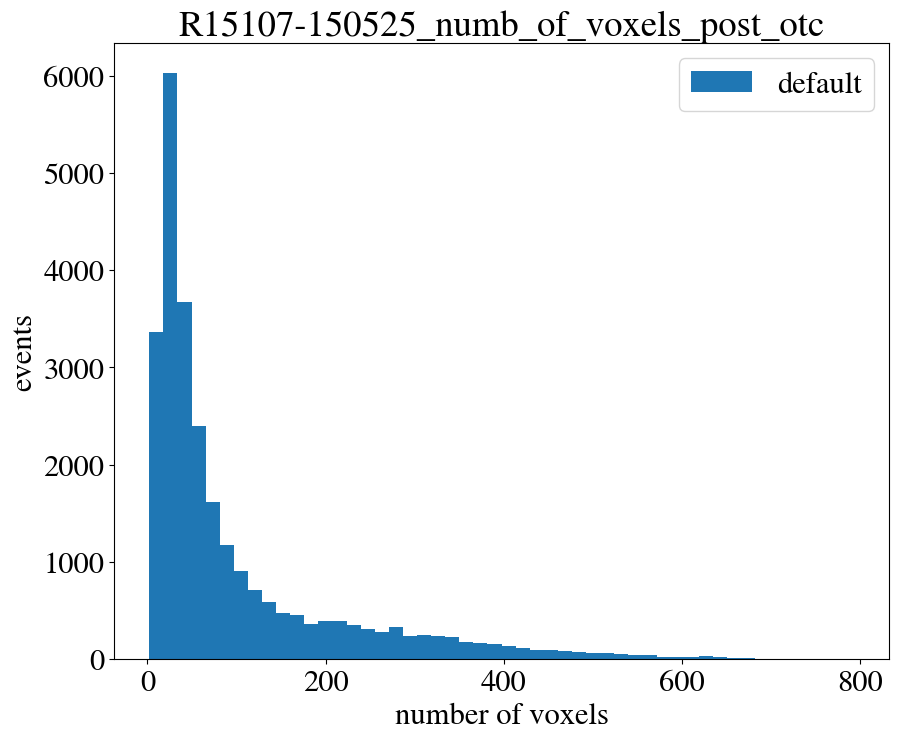

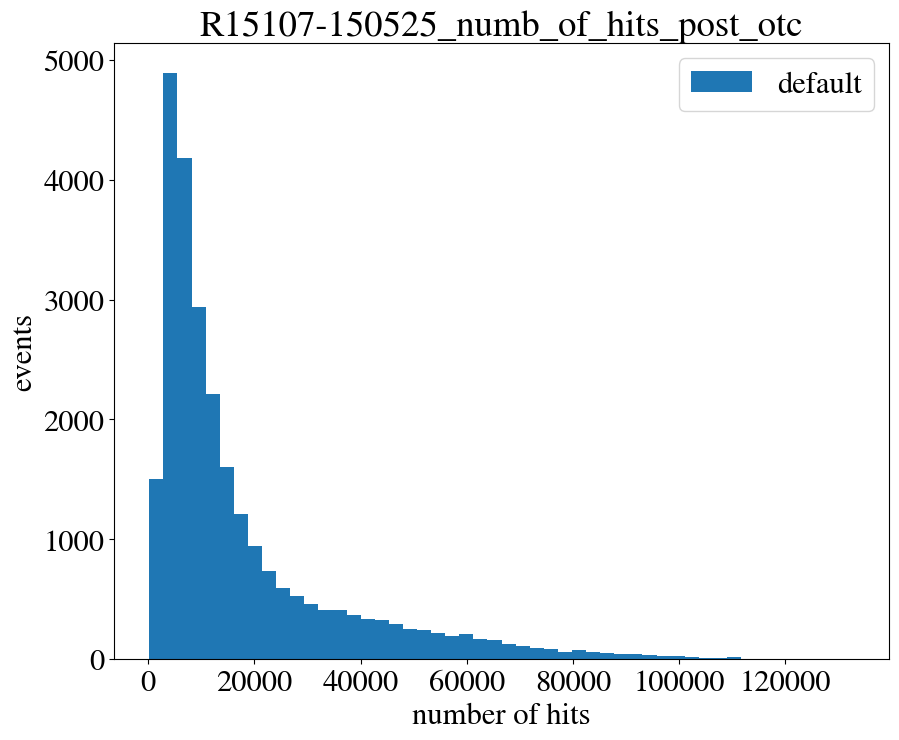

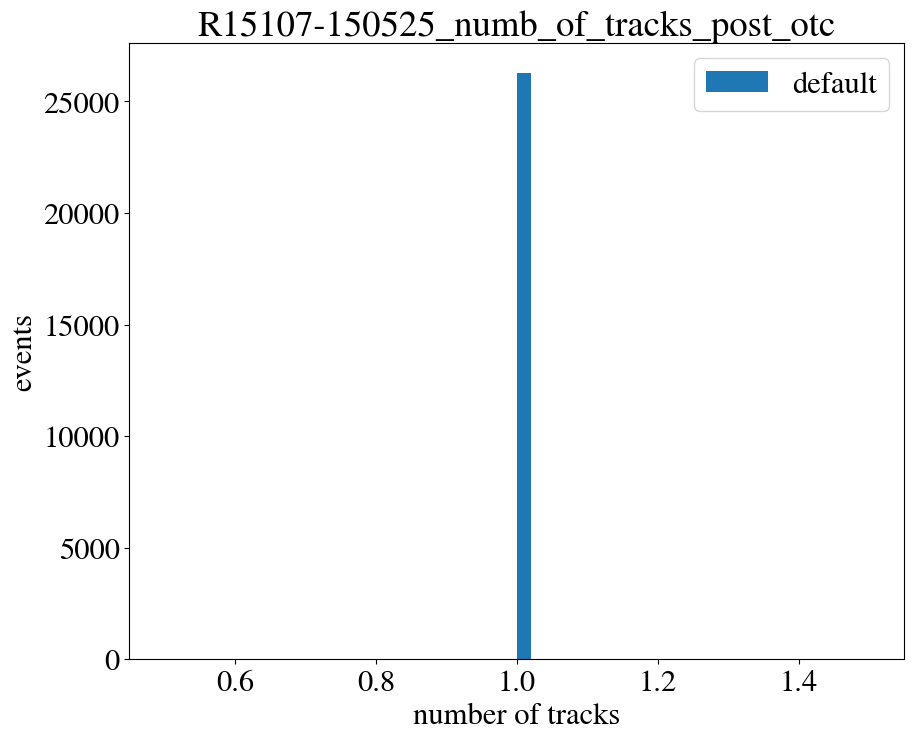

In [72]:
# plot track related shenanigans
for vars, labels in zip(top_vars, top_labels):
    func.plot_hist( ot_hdst
                  , vars
                  , binning  = 50
                  , title    = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_otc'
                  , x_label  = f'{labels}'
                  , outliers = (0, 99.99999)
                  , log      = log_flag
                  , output   = True
                  , save     = True
                  , save_dir = f'{folder_name}topology/')

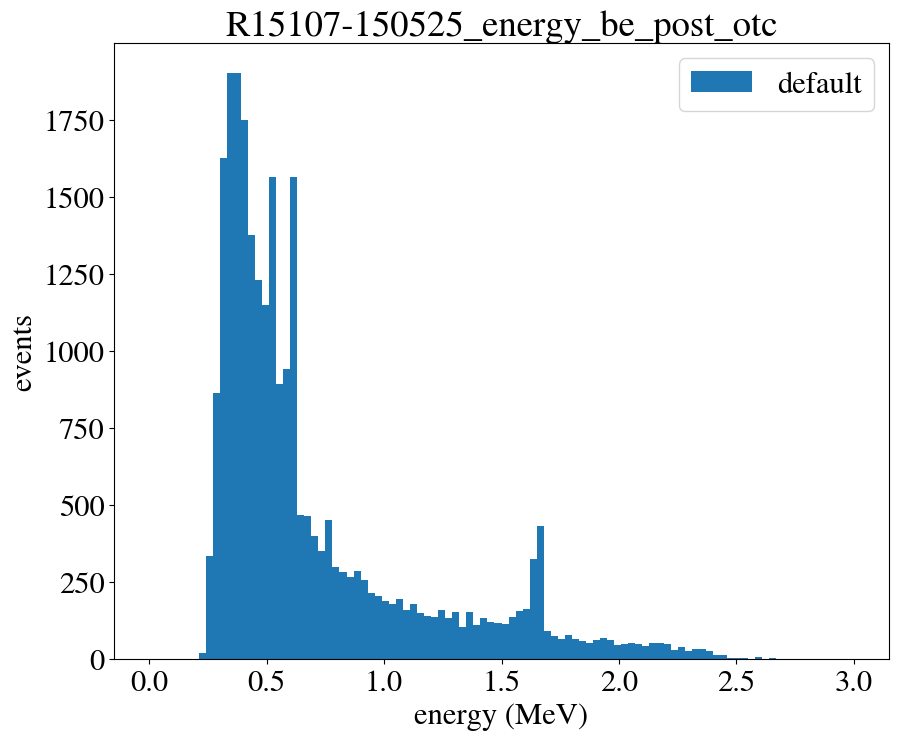

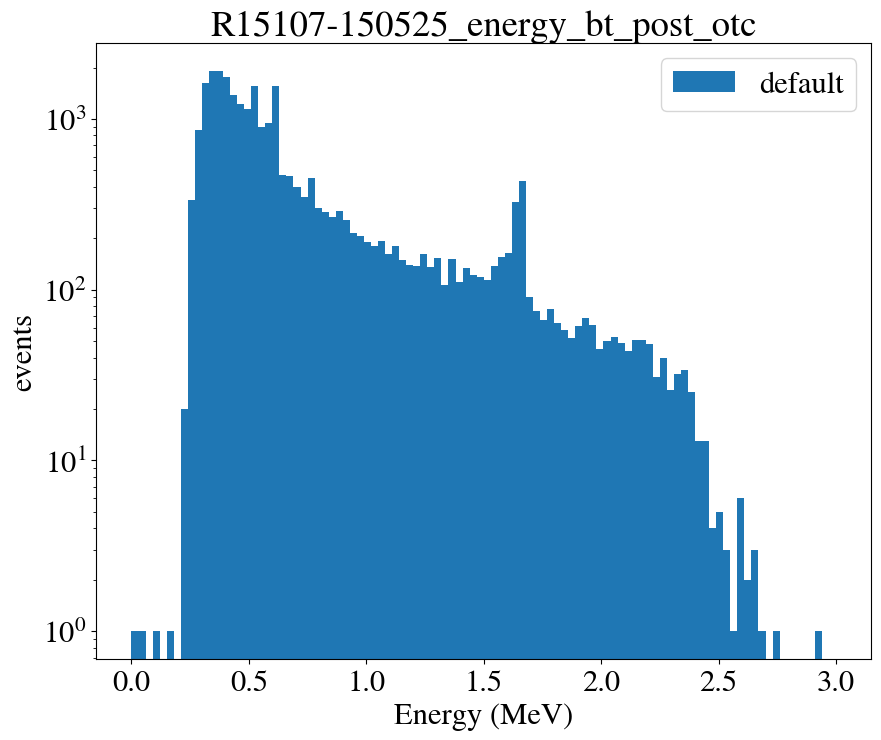

In [73]:
func.plot_hist_over_column(  ot_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_otc'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( ot_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_otc'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# overlap cut

In [74]:
ovlp_hdst = func.overlapping_cuts(ot_hdst)

_ = func.cut_effic(ovlp_hdst, ot_hdst, verbose = True)

Efficiency: 50.32 %
Events in reduced dataframe: 13232
Events in initial dataframe: 26297


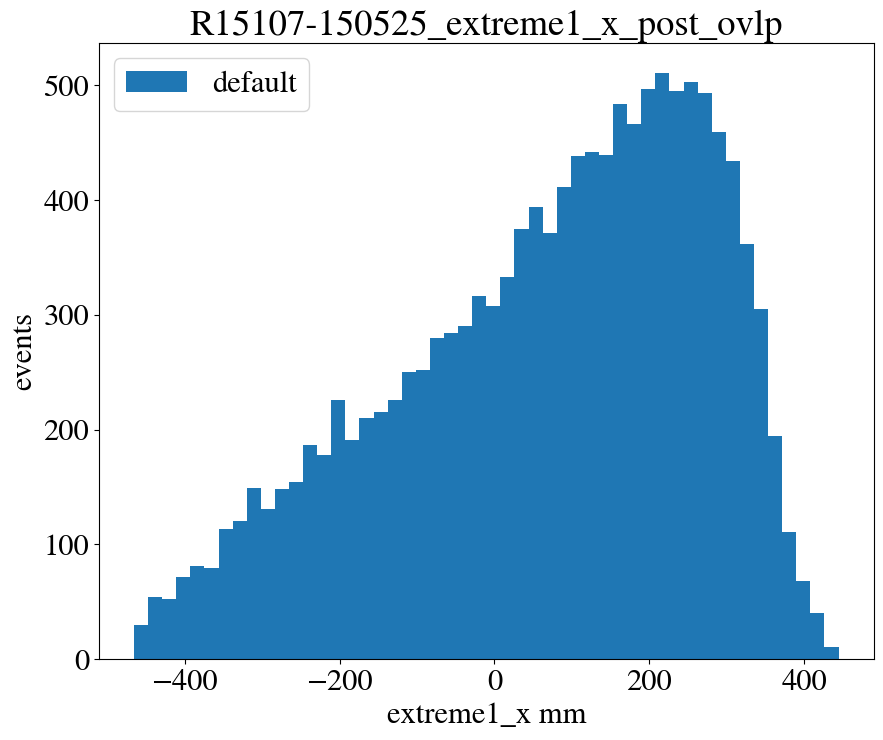

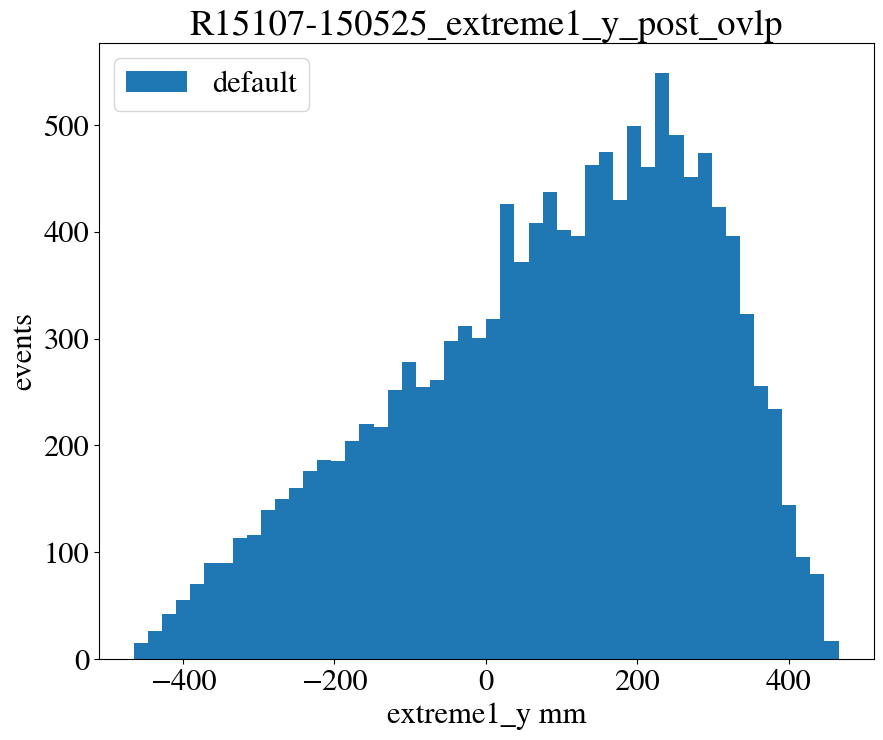

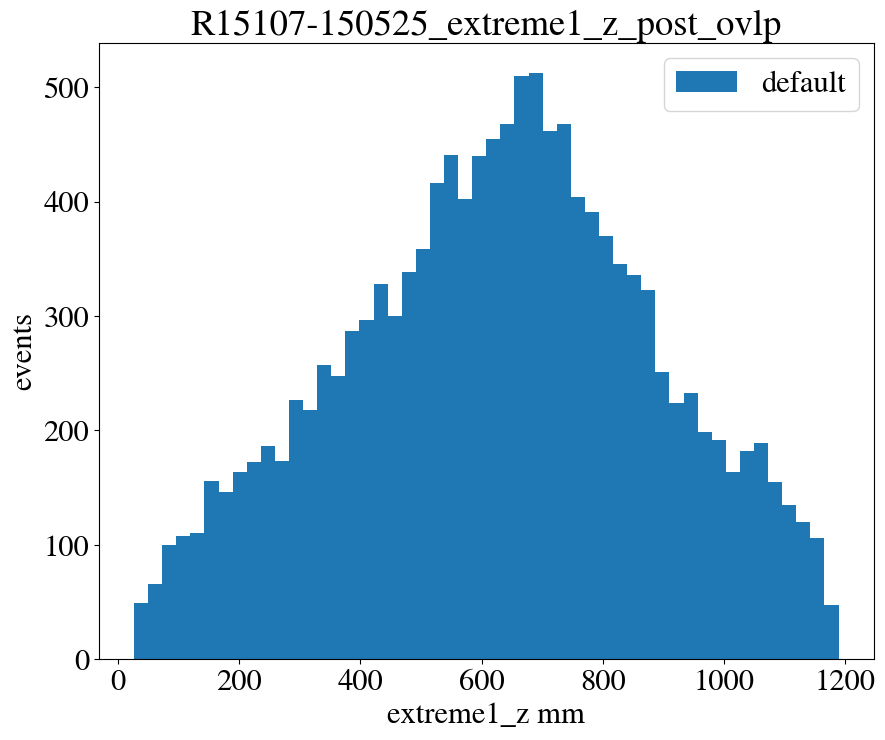

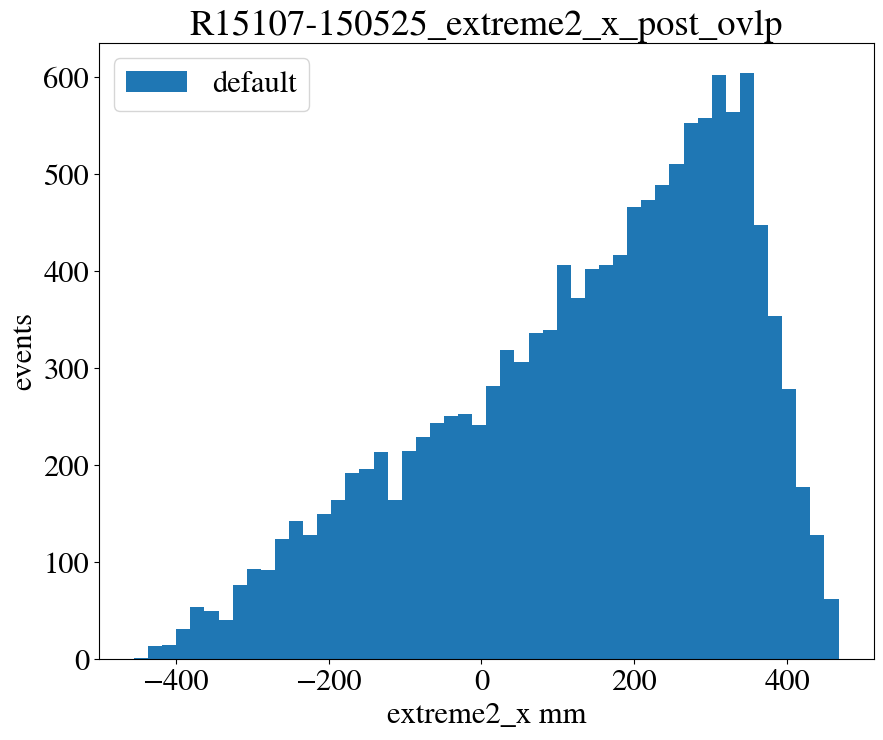

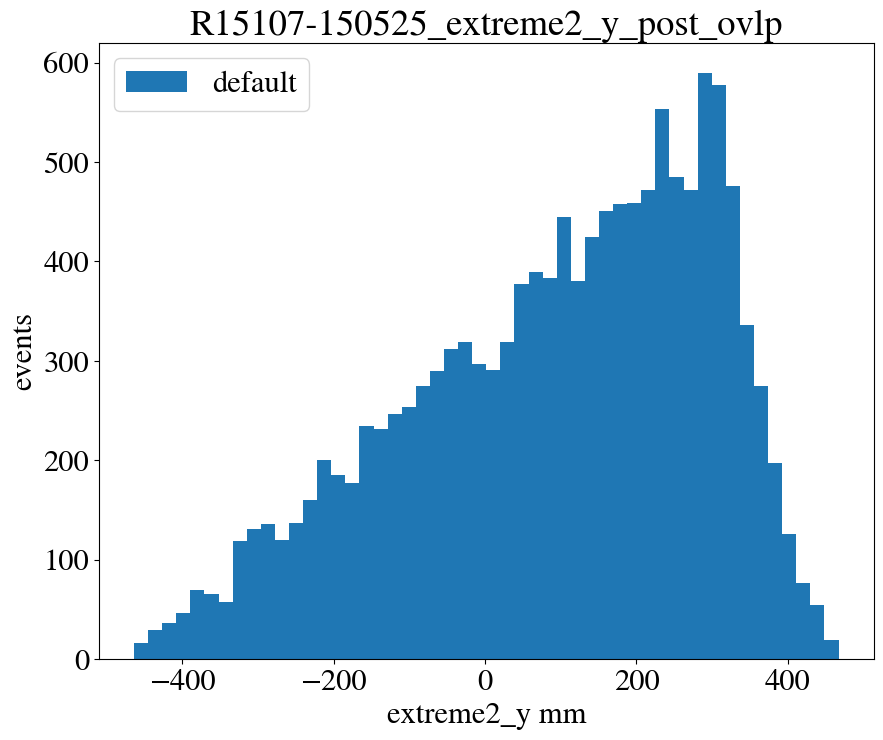

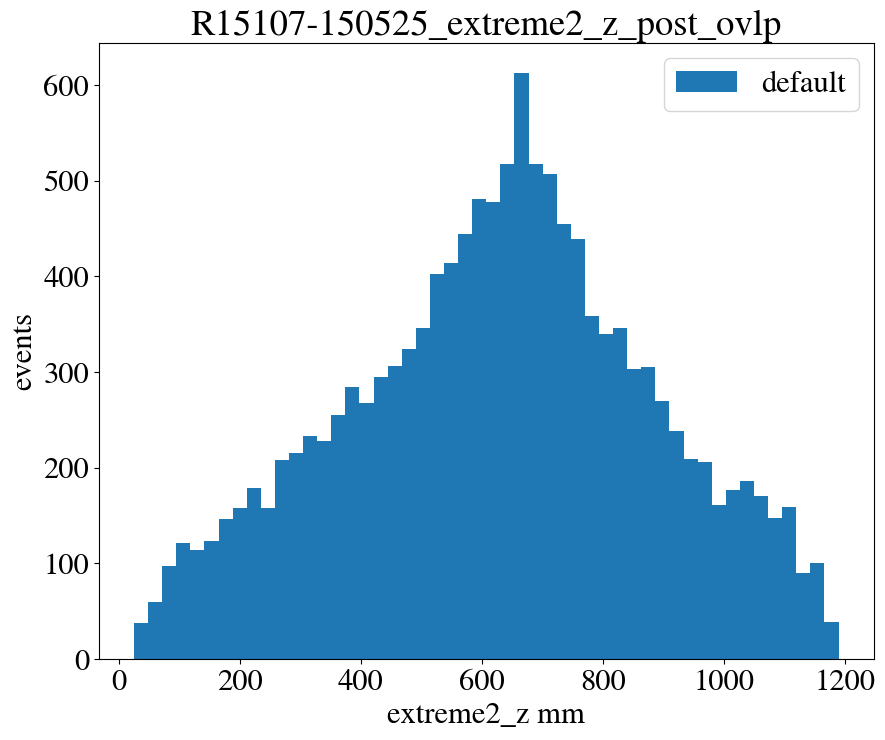

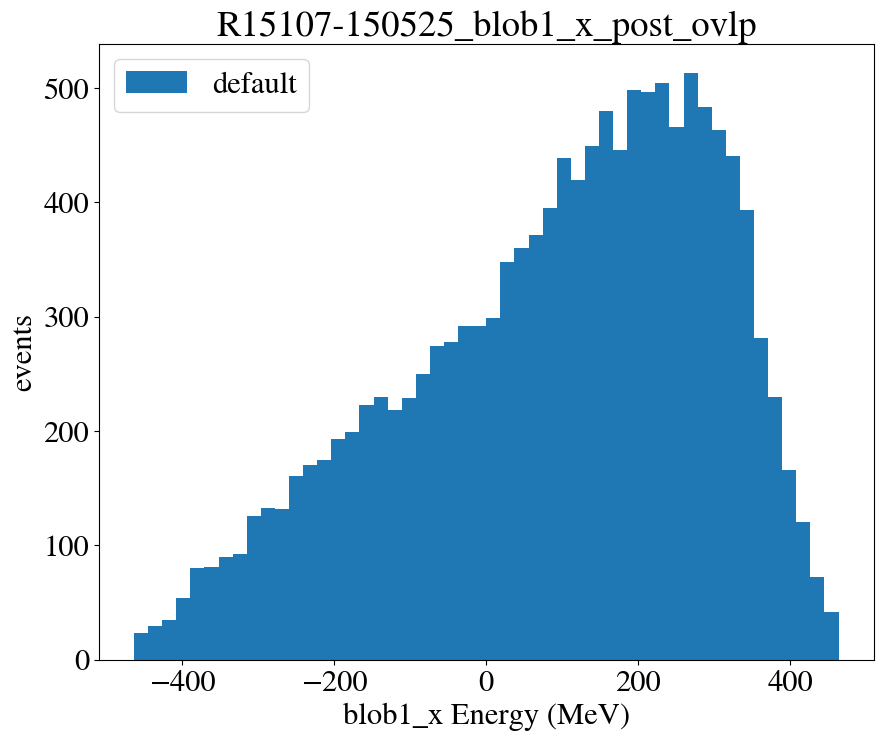

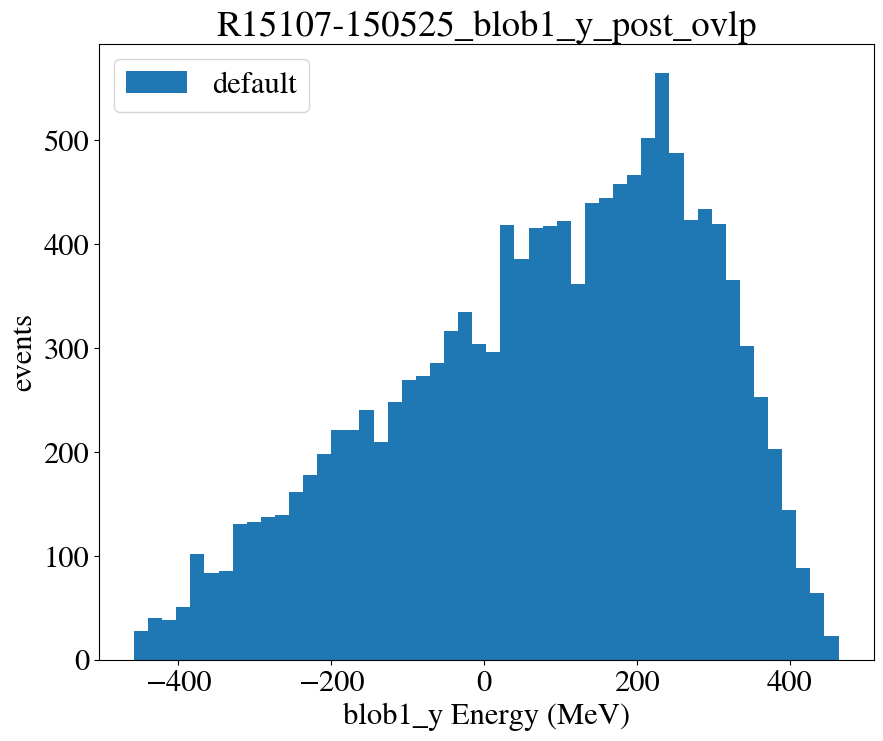

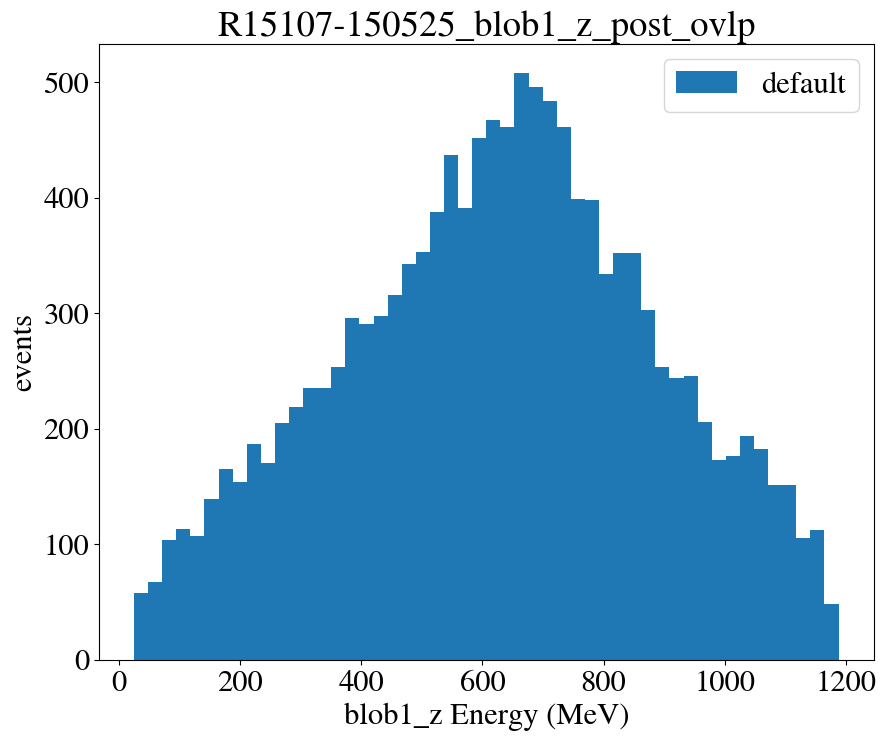

In [75]:
for vars, labels in zip(blob_vars, blob_labels):
    func.plot_hist( ovlp_hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_ovlp'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}blob/')

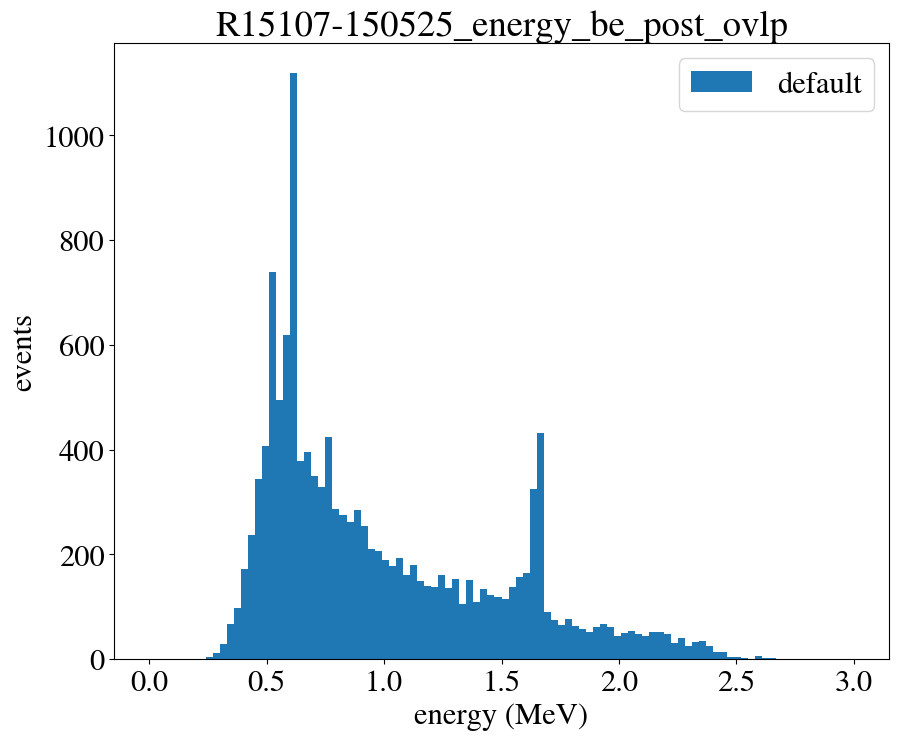

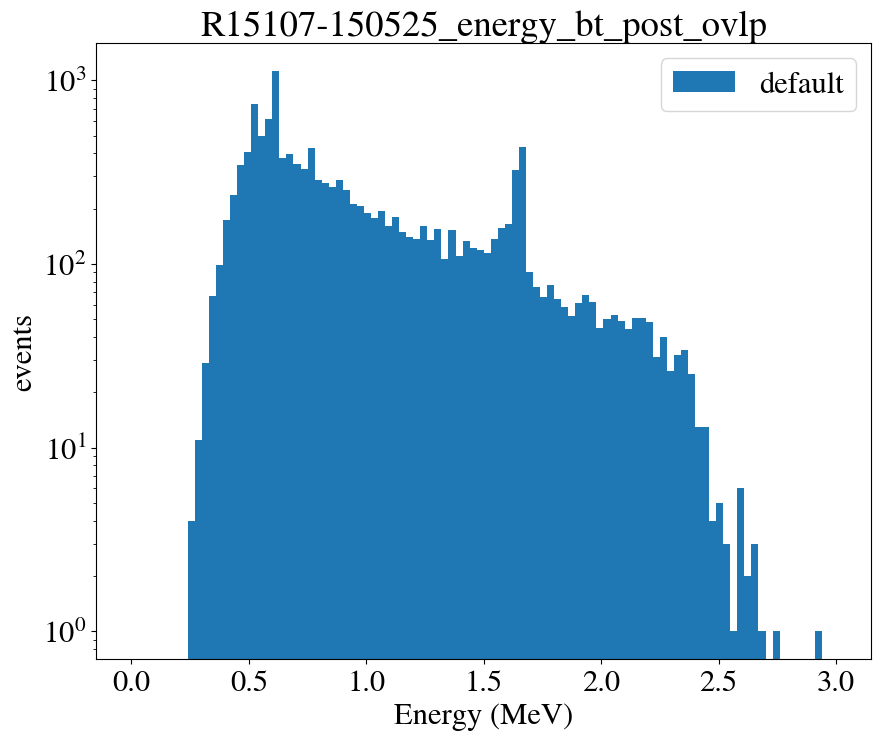

In [76]:
func.plot_hist_over_column(  ovlp_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_ovlp'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( ovlp_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_ovlp'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# energy cut

In [77]:
e_hdst = func.energy_cuts(ovlp_hdst
                         , lower_e = low_e
                         , upper_e = upp_e)

_ = func.cut_effic(e_hdst, ovlp_hdst, verbose = True)

Efficiency: 10.52 %
Events in reduced dataframe: 1392
Events in initial dataframe: 13232


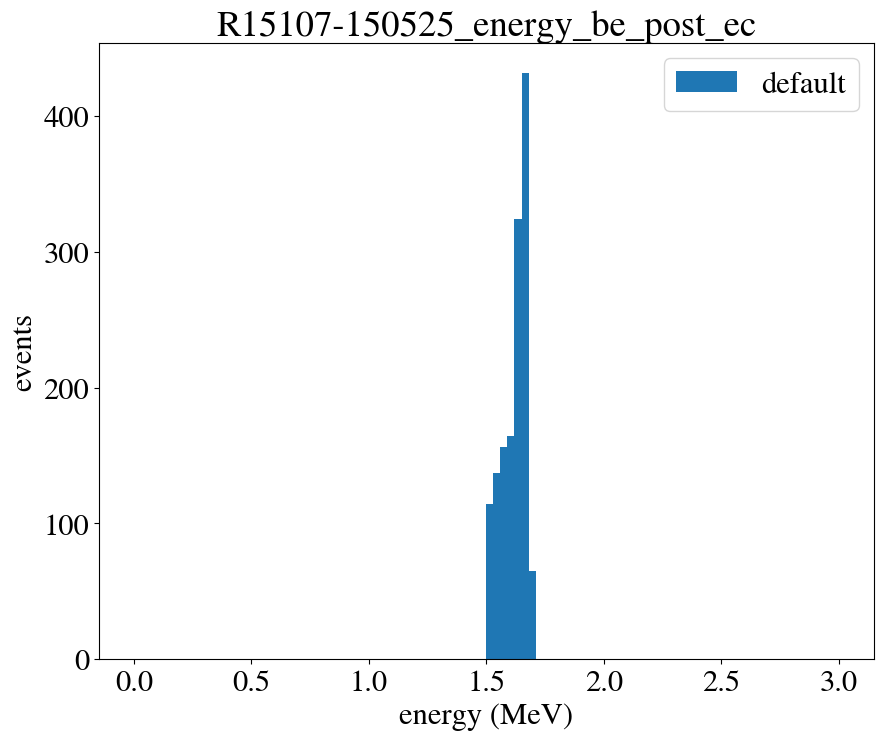

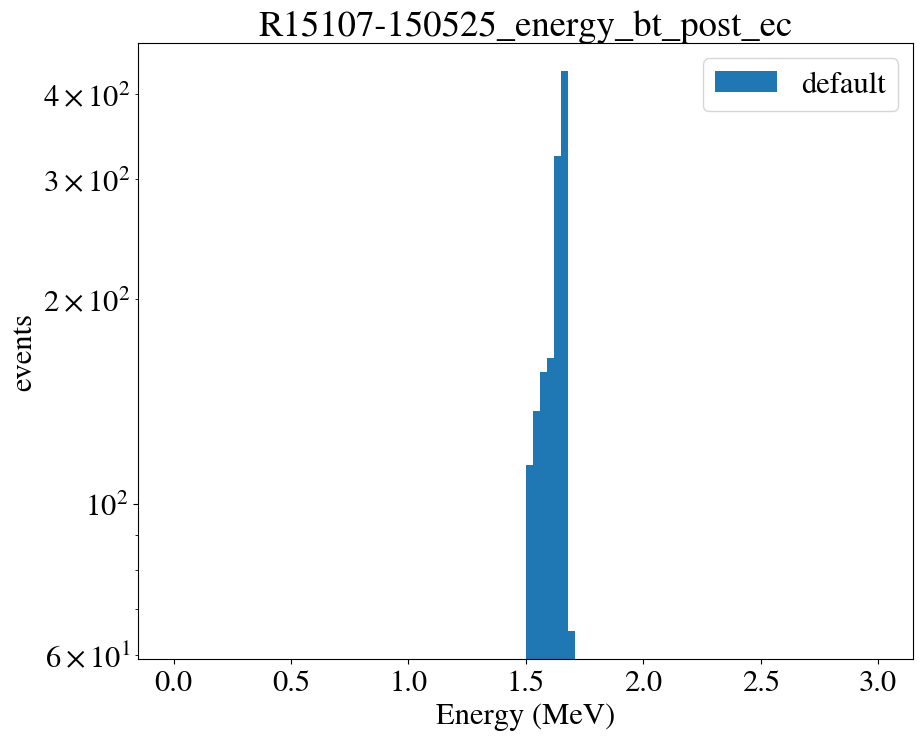

In [78]:
func.plot_hist_over_column(  e_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_ec'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( e_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_ec'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# Now plot the energy histograms atop each other

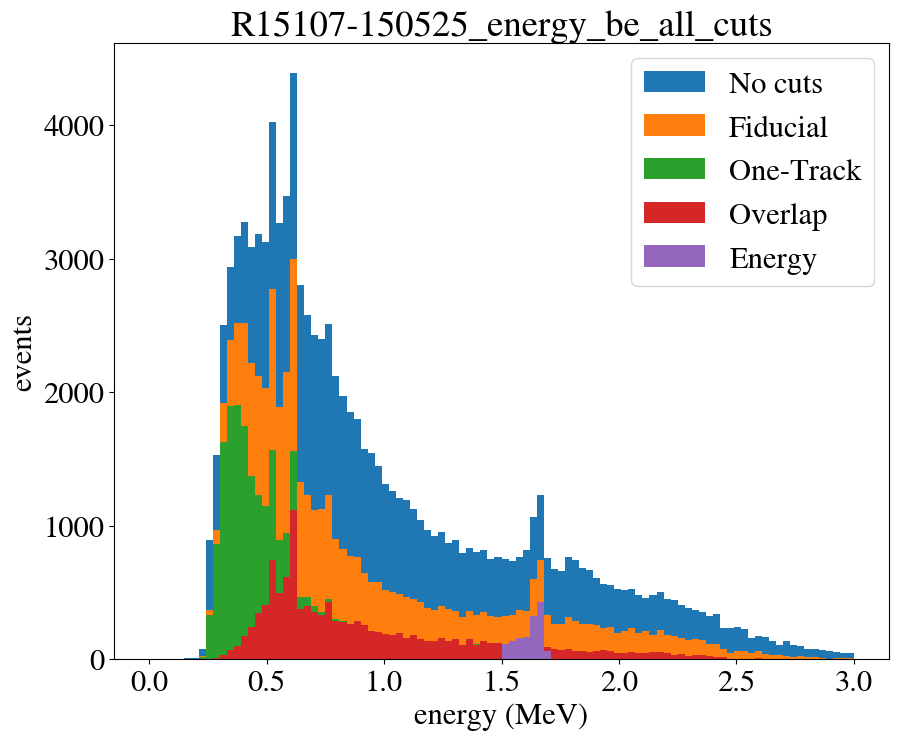

In [79]:
func.plot_hist_over_column(  hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , label = f'No cuts'
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  fid_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Fiducial'
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ot_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'One-Track'
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ovlp_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Overlap'
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  e_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Energy'
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_all_cuts'
                           , save = True
                           , save_dir = f'{folder_name}energy/')

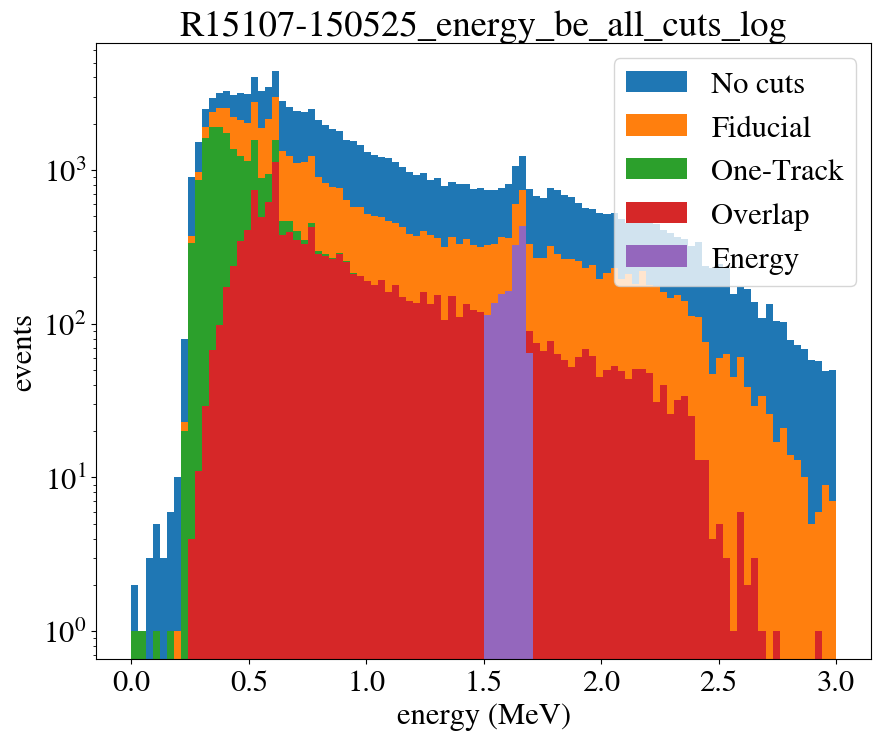

In [80]:
func.plot_hist_over_column(  hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = True
                           , label = f'No cuts'
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  fid_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Fiducial'
                           , log = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ot_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'One-Track'
                           , log = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ovlp_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Overlap'
                           , log = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  e_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Energy'
                           , log = True
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_all_cuts_log'
                           , save = True
                           , save_dir = f'{folder_name}energy/')

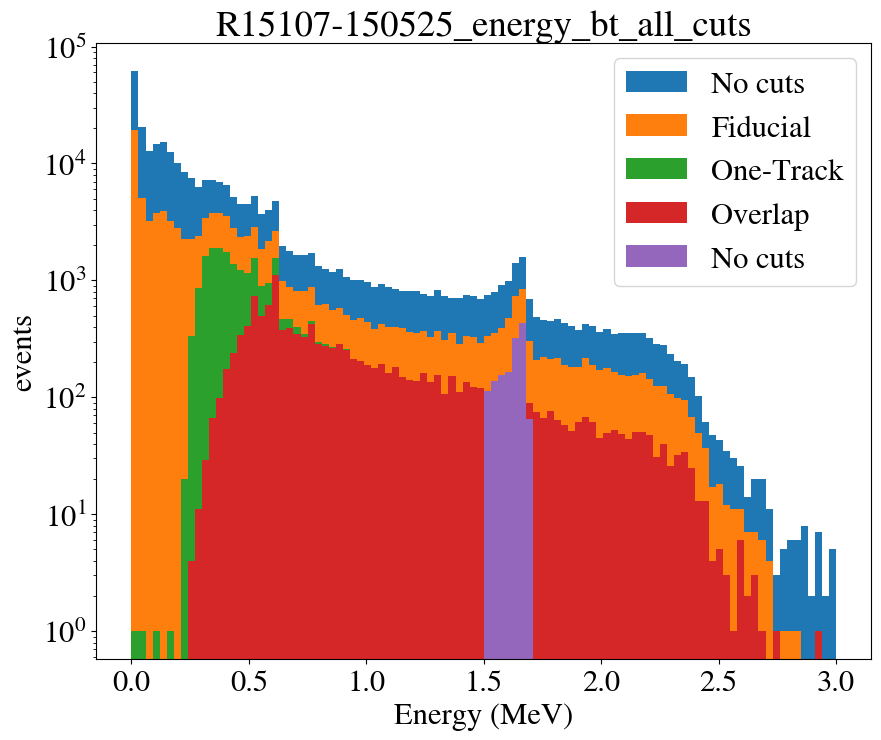

In [81]:
func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'No cuts')

func.plot_hist( fid_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'Fiducial')

func.plot_hist( ot_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'One-Track')


func.plot_hist( ovlp_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'Overlap')


func.plot_hist( e_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'No cuts'
              , output = True
              , save = True
              , save_dir = f'{folder_name}energy/')